# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [1]:
# import libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import psycopg2 as psy
%matplotlib inline 
# plt.style.use('ggplot')

#### Step 2: Examine your data 

In [2]:
# import CSVs 
airport = pd.read_csv('../assets/airports.csv')
cancel = pd.read_csv('../assets/airport_cancellations.csv')
operation = pd.read_csv('../assets/airport_operations.csv')

### Intro: Write a problem statement / aim for this project

In this project, we are given a set of preprocessed data that contains airport information, airport operation, and cancellation. Those data mainly describes the time, location, and flight on time/delay information. Since we have limited information on outside factors, in this project, we are focused on using flight delay information to predict what lead to cancellation and diversion in flights. 

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [228]:
# import library to connect SQL 
from psycopg2 import connect
import sys
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
%load_ext sql
# connecting to local host 
con = connect(user='Lydia', host='localhost')
con.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
cur = con.cursor()
# creating database in SQL server 
cur.execute('create Database airport;')
# cur.execute('drop Database airport;')

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


ProgrammingError: database "airport" already exists


Load our csv files into tables

In [229]:
from sqlalchemy import create_engine
# create engine to run sql commands 
engine = create_engine('postgresql://Lydia@localhost:5432/airport')

In [230]:
# write a function that reads CSV files into SQL as tables 
def load_to_sql(name):
    df = pd.read_csv('../assets/{}.csv'.format(name), encoding='latin1')
    df.to_sql(name, engine, flavor='postgres', if_exists='replace')
    print "done", name

In [231]:
# run each 
load_to_sql('airports')
load_to_sql('airport_cancellations')
load_to_sql('airport_operations')

done airports
done airport_cancellations
done airport_operations


Join airport_cancellations.csv and airports.csv into one table

In [232]:
# connect to postgres database 
%sql postgresql://Lydia@localhost:5432/airport

u'Connected: Lydia@airport'

In [233]:
# try to run sql queries to check the tables 
%%sql
select * from airports limit 5;

5 rows affected.


[(0L, 3443.0, u'STX', u'HENRY E ROHLSEN', u"Henry E Rohlsen Int'l Airport", u'Airport', u'ASO', u'-VIRGIN ISLANDS-', u'CHRISTIANSTED', u'VI', u'Public Use', 17.701556, -64.801722, u'Yes'),
 (1L, 5088.0, u'X64', u'PATILLAS', None, u'Airport', u'ASO', u'#NAME?', u'PATILLAS', u'PR', u'Public Use', 17.982189, -66.01933, u'No'),
 (2L, 2886.0, u'PSE', u'MERCEDITA', u'Aeropuerto Mercedita', u'Airport', u'ASO', u'#NAME?', u'PONCE', u'PR', u'Public Use', 18.008306, -66.563028, u'Yes'),
 (3L, 2879.0, u'VQS', u'ANTONIO RIVERA RODRIGUEZ', u'Aeropuerto Antonio Rivera Rodr\xef\xbf\xbdguez', u'Airport', u'ASO', u'#NAME?', u'ISLA DE VIEQUES', u'PR', u'Public Use', 18.134811, -65.493617, u'Yes'),
 (4L, 2883.0, u'X63', u'HUMACAO', u'Aeropuerto Regional De Humacao', u'Airport', u'ASO', u'#NAME?', u'HUMACAO', u'PR', u'Public Use', 18.138017, -65.800718, u'Yes')]

In [275]:
# check the cancellations table 
%%sql
select * from airport_cancellations limit 5;

5 rows affected.


[(0L, u'ABQ', 2004.0, 242.0, 235.0, 71.0, 46.0),
 (1L, u'ABQ', 2005.0, 221.0, 190.0, 61.0, 33.0),
 (2L, u'ABQ', 2006.0, 392.0, 329.0, 71.0, 124.0),
 (3L, u'ABQ', 2007.0, 366.0, 304.0, 107.0, 45.0),
 (4L, u'ABQ', 2008.0, 333.0, 300.0, 79.0, 42.0)]

In [276]:
# check the operations table 
%%sql
select * from airport_operations limit 5;

5 rows affected.


[(0L, u'ABQ', 2004L, 53971L, 53818L, 0.803, 0.7809, 0.7921, 10.38, 9.89, 2.43, 12.1, 2.46, 0.83, 2.55, 10.87),
 (1L, u'ABQ', 2005L, 51829L, 51877L, 0.814, 0.7922, 0.8001, 9.6, 9.79, 2.29, 11.2, 2.26, 0.89, 2.34, 10.24),
 (2L, u'ABQ', 2006L, 49682L, 51199L, 0.7983, 0.7756, 0.7746, 10.84, 9.89, 2.16, 12.33, 2.12, 0.84, 2.66, 11.82),
 (3L, u'ABQ', 2007L, 53255L, 53611L, 0.8005, 0.7704, 0.7647, 11.29, 10.34, 2.4, 12.95, 2.19, 1.29, 3.06, 12.71),
 (4L, u'ABQ', 2008L, 49589L, 49512L, 0.8103, 0.7844, 0.7875, 10.79, 10.41, 2.41, 12.32, 1.82, 1.03, 2.79, 11.48)]

In [242]:
# make some adjustments in columns for joining the tables
%%sql
ALTER TABLE airports RENAME COLUMN "LocID" to loc_id;
ALTER TABLE airport_cancellations RENAME COLUMN "Airport" to airport;
ALTER TABLE airport_cancellations RENAME COLUMN "Year" to year;

Done.
Done.
Done.


[]

In [278]:
# try joining tables 
%%sql
SELECT * from airports
FULL JOIN airport_cancellations
ON airports.loc_id = airport_cancellations.airport LIMIT 5;

5 rows affected.


[(0L, 3443.0, u'STX', u'HENRY E ROHLSEN', u"Henry E Rohlsen Int'l Airport", u'Airport', u'ASO', u'-VIRGIN ISLANDS-', u'CHRISTIANSTED', u'VI', u'Public Use', 17.701556, -64.801722, u'Yes', None, None, None, None, None, None, None),
 (1L, 5088.0, u'X64', u'PATILLAS', None, u'Airport', u'ASO', u'#NAME?', u'PATILLAS', u'PR', u'Public Use', 17.982189, -66.01933, u'No', None, None, None, None, None, None, None),
 (2L, 2886.0, u'PSE', u'MERCEDITA', u'Aeropuerto Mercedita', u'Airport', u'ASO', u'#NAME?', u'PONCE', u'PR', u'Public Use', 18.008306, -66.563028, u'Yes', None, None, None, None, None, None, None),
 (3L, 2879.0, u'VQS', u'ANTONIO RIVERA RODRIGUEZ', u'Aeropuerto Antonio Rivera Rodr\xef\xbf\xbdguez', u'Airport', u'ASO', u'#NAME?', u'ISLA DE VIEQUES', u'PR', u'Public Use', 18.134811, -65.493617, u'Yes', None, None, None, None, None, None, None),
 (4L, 2883.0, u'X63', u'HUMACAO', u'Aeropuerto Regional De Humacao', u'Airport', u'ASO', u'#NAME?', u'HUMACAO', u'PR', u'Public Use', 18.138017, -65.800718, u'Yes', None, None, None, None, None, None, None)]

In [241]:
# try joining tables 
%%sql
SELECT * from airports
FULL JOIN airport_cancellations
ON airports.loc_id = airport_cancellations.airport
FULL JOIN airport_operations
on airports.loc_id = airport_operations.airport;

(psycopg2.ProgrammingError) column airports.loc_id does not exist
LINE 3: ON airports.loc_id = airport_cancellations.airport
           ^
 [SQL: 'SELECT * from airports\nFULL JOIN airport_cancellations\nON airports.loc_id = airport_cancellations.airport\nFULL JOIN airport_operations\non airports.loc_id = airport_operations.airport;']


In [244]:
# join all three tables based on 2 columns 
%%sql
SELECT * from airport_operations
JOIN airport_cancellations
ON (airport_operations.airport = airport_cancellations.airport and airport_operations.year = airport_cancellations.year)
JOIN airports
on airports.loc_id = airport_cancellations.airport;

799 rows affected.


[(744L, u'SJU', 2014L, 43671L, 42965L, 0.8056, 0.7784, 0.7815, 11.71, 12.89, 1.88, 13.13, 1.81, 1.0, 2.93, 12.79, 727L, u'SJU', 2014.0, 280.0, 241.0, 72.0, 31.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (743L, u'SJU', 2013L, 42902L, 42175L, 0.8058, 0.7808, 0.784, 12.31, 13.56, 2.2, 13.52, 1.78, 1.41, 2.86, 12.96, 726L, u'SJU', 2013.0, 127.0, 94.0, 65.0, 64.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (742L, u'SJU', 2012L, 44716L, 43985L, 0.8417, 0.8228, 0.8181, 9.55, 13.15, 1.82, 10.55, 1.41, 1.33, 2.89, 10.64, 725L, u'SJU', 2012.0, 174.0, 141.0, 62.0, 41.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (741L, u'SJU', 2011L, 42803L, 42401L, 0.8179, 0.7934, 0.7899, 10.86, 13.23, 1.96, 12.07, 1.45, 1.57, 3.67, 12.28, 724L, u'SJU', 2011.0, 240.0, 201.0, 101.0, 55.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (740L, u'SJU', 2010L, 47314L, 45781L, 0.7967, 0.7815, 0.7719, 12.21, 13.04, 1.39, 13.0, 1.65, 1.32, 3.53, 13.4, 723L, u'SJU', 2010.0, 258.0, 207.0, 82.0, 45.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (739L, u'SJU', 2009L, 48418L, 46678L, 0.8168, 0.8015, 0.7999, 11.44, 13.29, 1.43, 12.28, 1.22, 0.95, 2.88, 11.77, 722L, u'SJU', 2009.0, 199.0, 159.0, 57.0, 58.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (738L, u'SJU', 2008L, 44493L, 43448L, 0.8004, 0.781, 0.7533, 12.54, 14.22, 1.85, 13.59, 1.64, 1.25, 3.75, 15.18, 721L, u'SJU', 2008.0, 238.0, 197.0, 78.0, 29.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (737L, u'SJU', 2007L, 47987L, 47246L, 0.8014, 0.7522, 0.7414, 12.53, 15.22, 3.16, 14.97, 1.55, 1.71, 4.09, 16.31, 720L, u'SJU', 2007.0, 307.0, 278.0, 70.0, 42.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (736L, u'SJU', 2006L, 55707L, 52948L, 0.8054, 0.7446, 0.7611, 11.61, 15.75, 4.28, 14.34, 1.73, 1.29, 4.19, 14.17, 719L, u'SJU', 2006.0, 257.0, 233.0, 63.0, 44.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (735L, u'SJU', 2005L, 57736L, 54870L, 0.7789, 0.7464, 0.7604, 12.74, 14.14, 3.03, 14.43, 1.63, 1.36, 4.04, 14.65, 718L, u'SJU', 2005.0, 315.0, 282.0, 64.0, 36.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes'),
 (734L, u'SJU', 2004L, 60371L, 56735L, 0.8019, 0.7794, 0.7984, 11.19, 13.84, 2.27, 12.43, 1.88, 0.79, 3.39, 12.28, 717L, u'SJU', 2004.0, 330.0, 289.0, 55.0, 28.0, 10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Feder

In [249]:
# save the joined tables to a pandas dataframe 
final = "SELECT * from airport_operations JOIN airport_cancellations ON (airport_operations.airport = airport_cancellations.airport and airport_operations.year = airport_cancellations.year) JOIN airports on airports.loc_id = airport_cancellations.airport;"
df = pd.read_sql_query(final,engine)

Query the database for our intial data

In [252]:
# check the new dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 37 columns):
index                                 799 non-null int64
airport                               799 non-null object
year                                  799 non-null int64
departures for metric computation     799 non-null int64
arrivals for metric computation       799 non-null int64
percent on-time gate departures       799 non-null float64
percent on-time airport departures    799 non-null float64
percent on-time gate arrivals         799 non-null float64
average_gate_departure_delay          799 non-null float64
average_taxi_out_time                 799 non-null float64
average taxi out delay                799 non-null float64
average airport departure delay       799 non-null float64
average airborne delay                799 non-null float64
average taxi in delay                 799 non-null float64
average block delay                   799 non-null float64
average gate arriva

In [3]:
# use pandas merge to double check the joined tables
temp = operation.merge(cancel, left_on=('airport','year'), right_on = ('Airport','Year'), how = 'inner')
df = temp.merge(airport, left_on='airport', right_on = 'LocID', how = 'left')

In [4]:
# save the new dataframe to a csv
df.to_csv('airport_final.csv')

#### 1.2 What are the risks and assumptions of our data? 

In this project, we are given a set of preprocessed data that contains airport information, airport operation, and cancellation. Those data mainly describes the time, location, and flight on time/delay information. There are 799 records in total, including 74 airports and 11 years (2004-2014). Since we have limited information on outside factors, in this project, we are focused on using flight delay information to predict what lead to cancellation and diversion in flights. We might not have enough data that confirms what exactly in the delay that caused cancellation and diversion, such as weather, airplane efficiency, etc... Also, four airports are missing 3-5 years of records, and that might skew the result.  


### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [5]:
# import libraries for analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [6]:
# basic description on numeric columns 
df.describe()

year  departures for metric computation  \
count   799.000000                         799.000000   
mean   2009.016270                      113471.568210   
std       3.150126                       98059.144667   
min    2004.000000                         731.000000   
25%    2006.000000                       42064.000000   
50%    2009.000000                       79489.000000   
75%    2012.000000                      166469.500000   
max    2014.000000                      491826.000000   

       arrivals for metric computation  percent on-time gate departures  \
count                       799.000000                       799.000000   
mean                     113003.959950                         0.779123   
std                       97705.308115                         0.052279   
min                         717.000000                         0.529900   
25%                       42006.500000                         0.753100   
50%                       79750.000000                         0.784100   
75%                      165560.500000                         0.810700   
max                      486799.000000                         0.909700   

       percent on-time airport departures  percent on-time gate arrivals  \
count                          799.000000                     799.000000   
mean                             0.726958                       0.766864   
std                              0.076027                       0.050502   
min                              0.380800                       0.513600   
25%                              0.691800                       0.742150   
50%                              0.740200                       0.770500   
75%                              0.773700                       0.797600   
max                              0.897400                       0.880300   

       average_gate_departure_delay  average_taxi_out_time  \
count                    799.000000             799.000000   
mean                      12.890250              13.872879   
std                        3.036474               3.806217   
min                        5.350000               7.240000   
25%                       10.830000              11.475000   
50%                       12.540000              12.940000   
75%                       14.620000              15.745000   
max                       25.840000              35.760000   

       average taxi out delay  average airport departure delay     ...      \
count              799.000000                       799.000000     ...       
mean                 3.683292                        15.703504     ...       
std                  2.337325                         4.364217     ...       
min                  0.100000                         6.290000     ...       
25%                  2.300000                        12.890000     ...       
50%                  3.050000                        15.130000     ...       
75%                  4.220000                        17.555000     ...       
max                 18.940000                        40.510000     ...       

       average block delay  average gate arrival delay         Year  \
count           799.000000                  799.000000   799.000000   
mean              3.290826                   13.428811  2009.016270   
std               0.989275                    3.251647     3.150126   
min               1.330000                    6.330000  2004.000000   
25%               2.615000                   11.270000  2006.000000   
50%               3.130000                   12.970000  2009.000000   
75%               3.815000                   14.935000  2012.000000   
max               7.520000                   27.780000  2014.000000   

       Departure Cancellations  Arrival Cancellations  Departure Diversions  \
count               799.000000             799.000000            799.000000   
mean               1299.314143            1341.068836            174.250313   


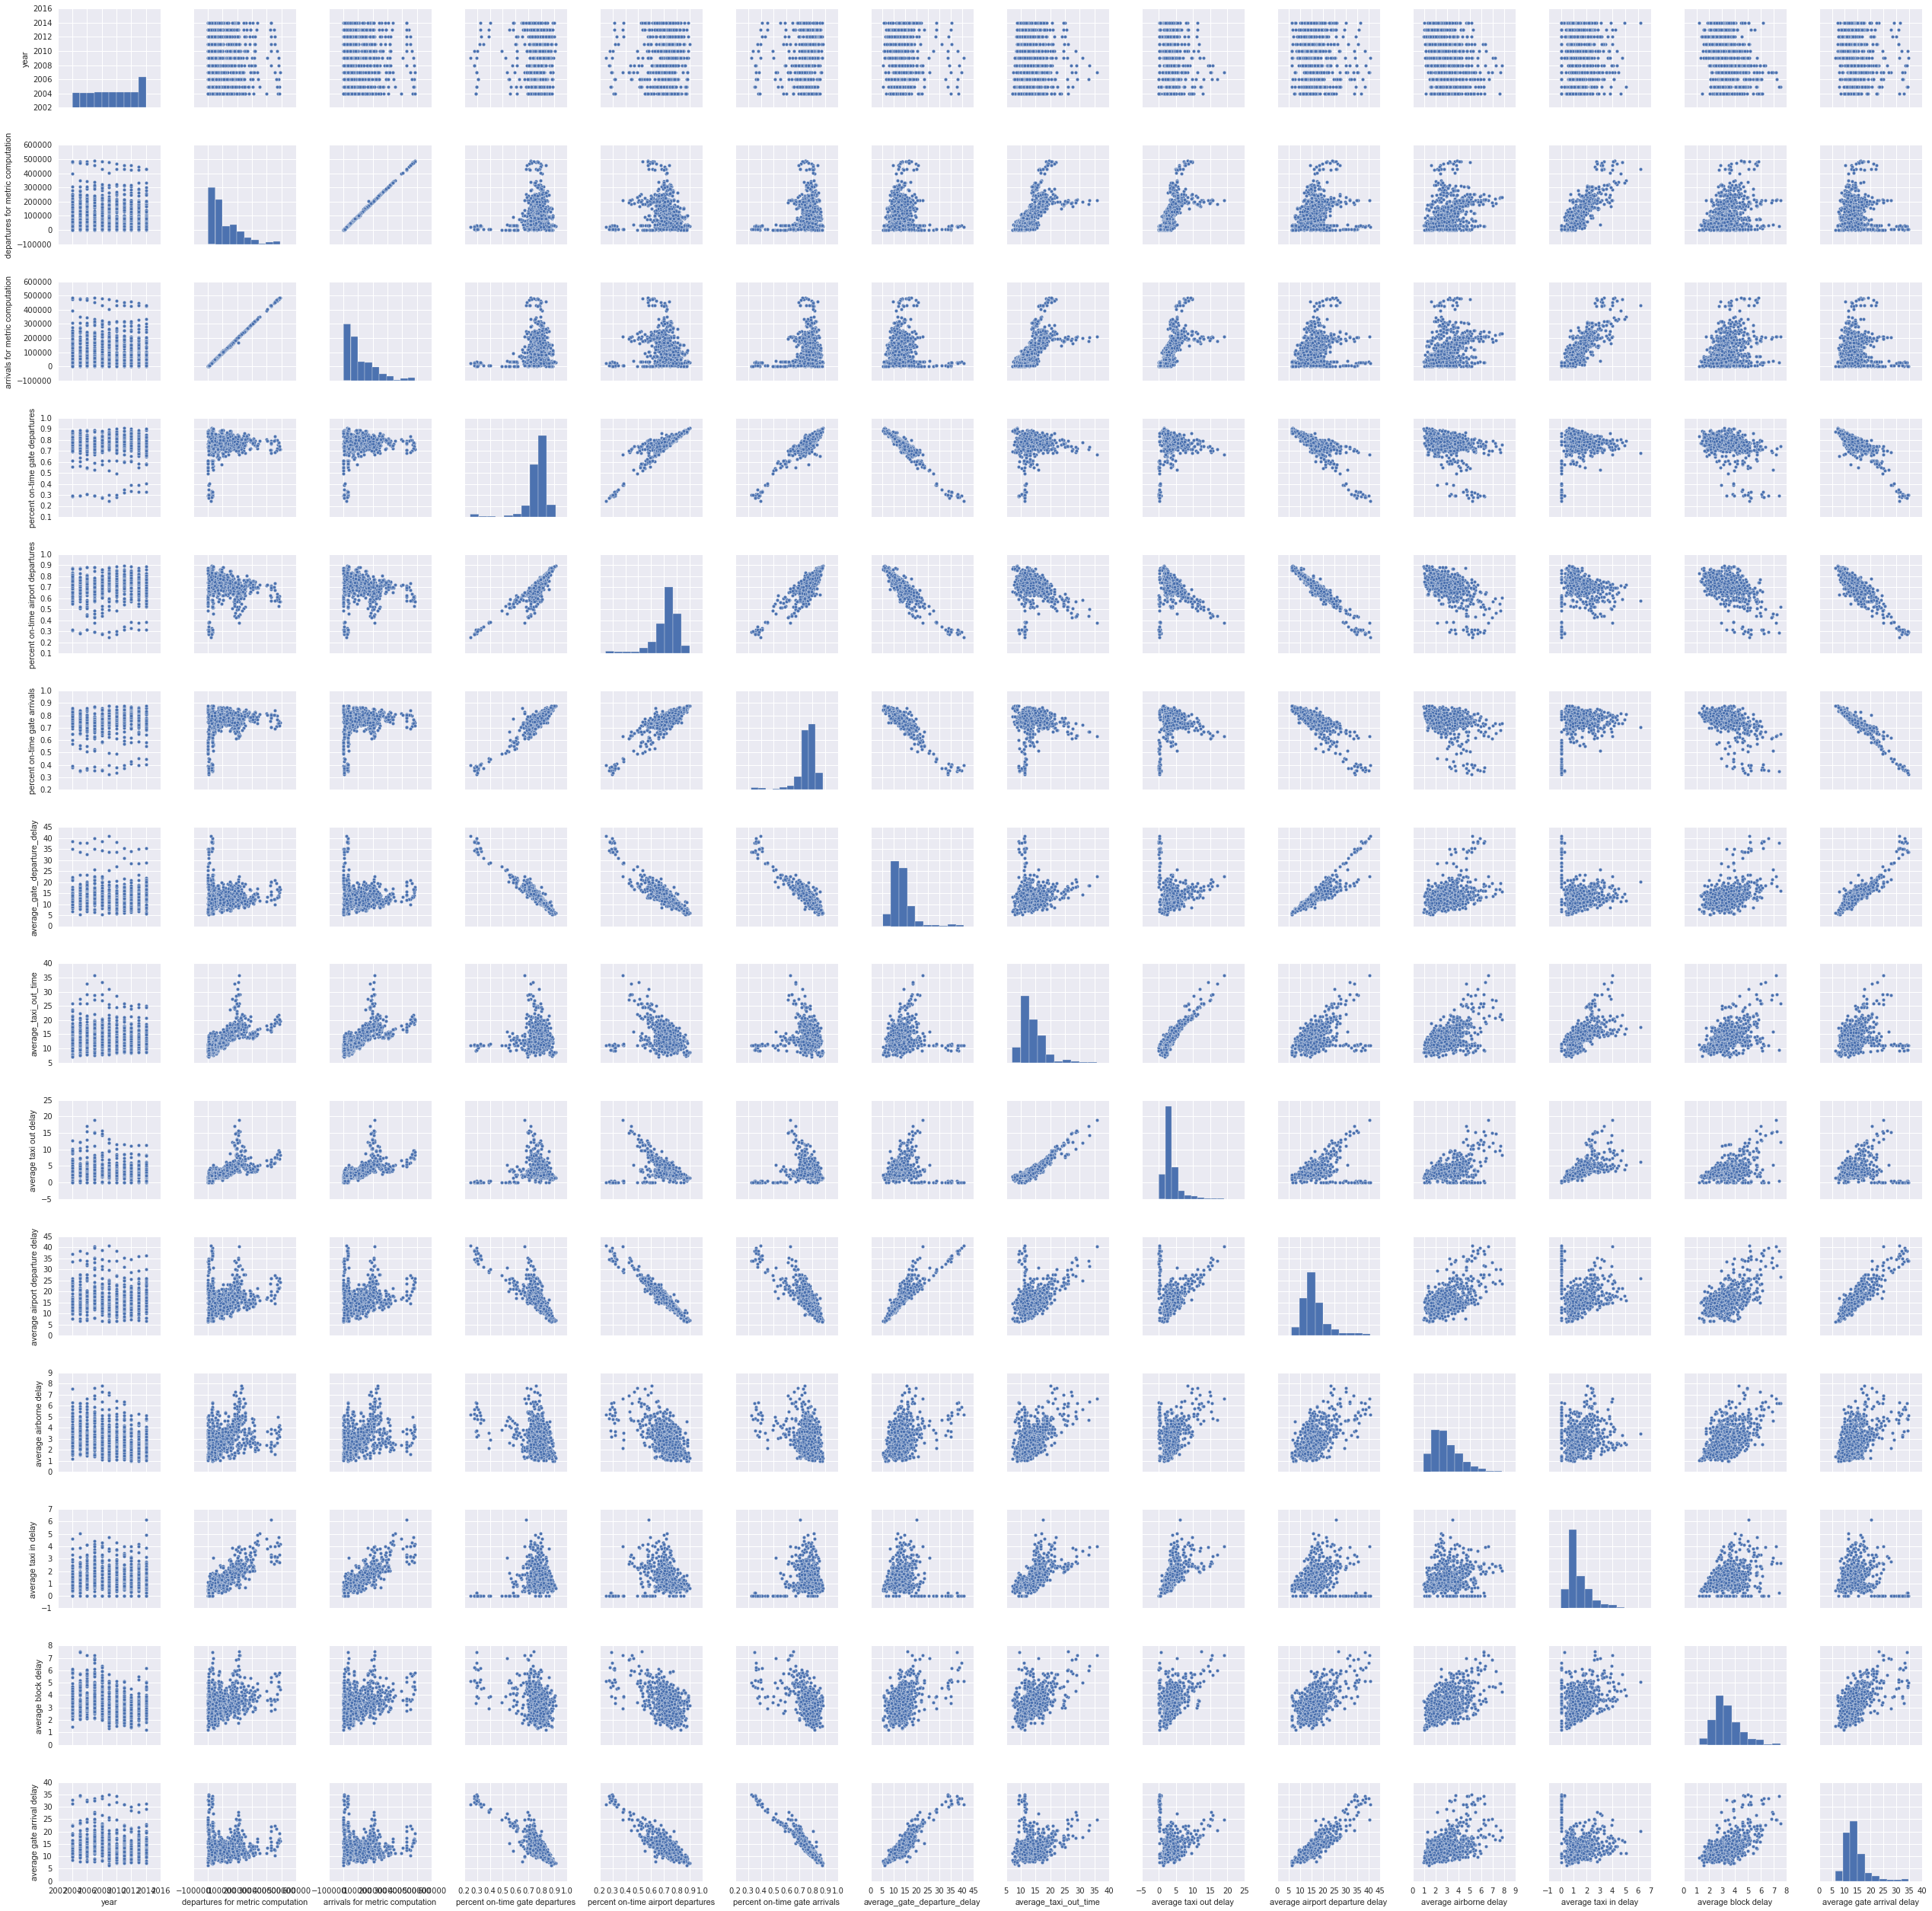

In [223]:
# quick look at all the relationships between all the columns 
sns.pairplot(operation)

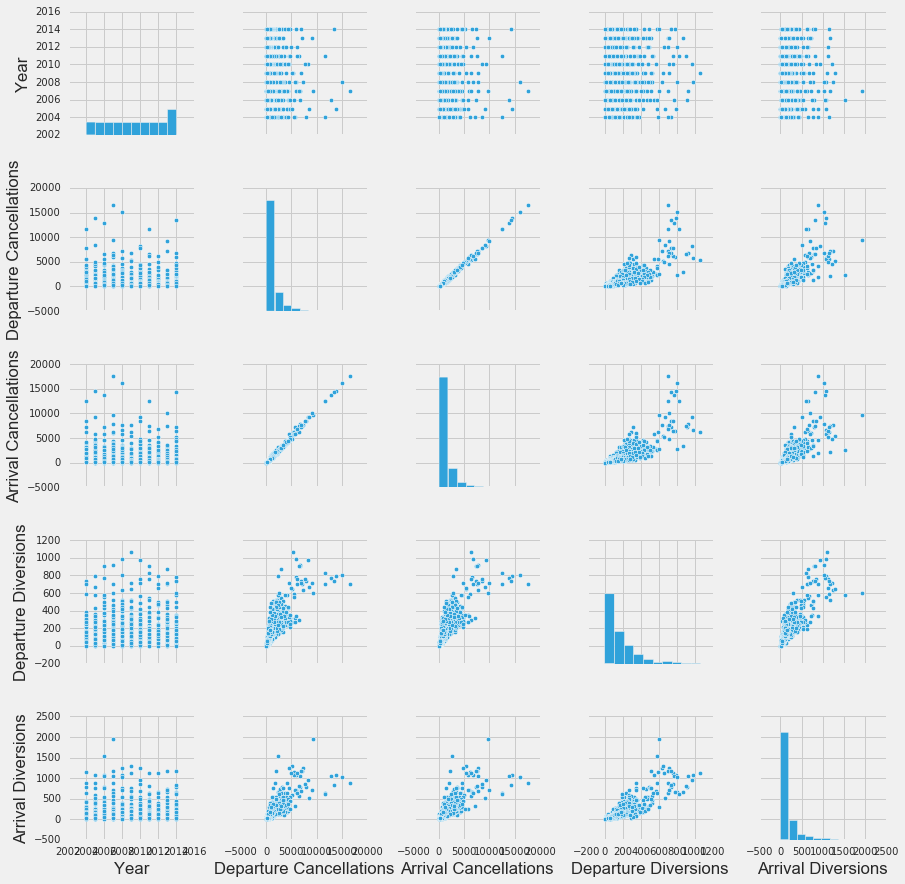

In [17]:
# quick look at the cancellation information
sns.pairplot(cancel)

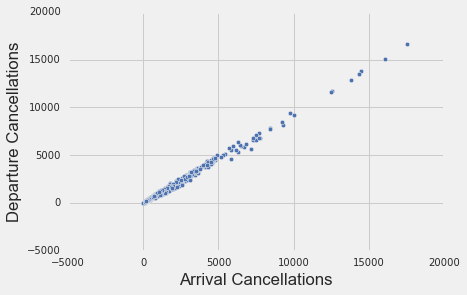

In [18]:
# the relationship between arrival cancellations and departure cancellations 
df.plot(kind='scatter',x= 'Arrival Cancellations',y='Departure Cancellations')

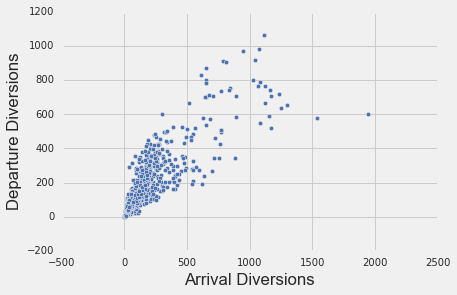

In [19]:
# the relationship between arrival diversions and departure diversions 
df.plot(kind='scatter',x= 'Arrival Diversions',y='Departure Diversions')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cbe7a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12070eed0>]], dtype=object)

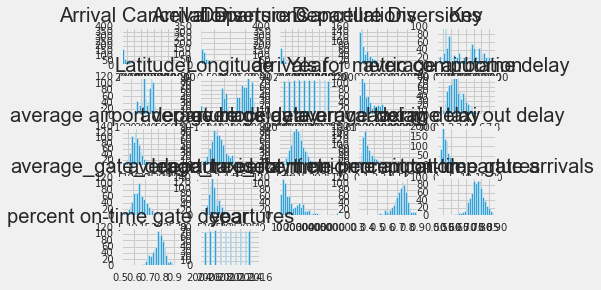

In [22]:
# quick look at if data is normally distributed
plt.figure(figsize = (16,12))
df.hist(bins = 30)

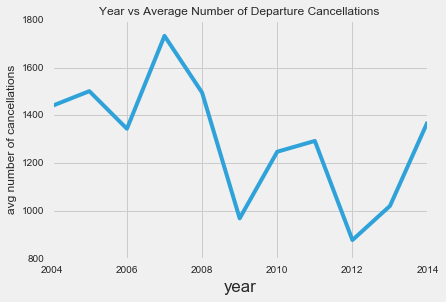

In [49]:
# check the trend in departure cancelation
temp = pd.pivot_table(df, index = 'year', values = 'cancel_dep')
plt.figure()
temp.plot()
plt.title('Year vs Average Number of Departure Cancellations', fontsize =12)
plt.ylabel('avg number of cancellations', fontsize =12)

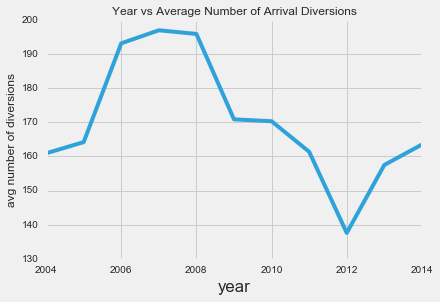

In [50]:
# check the trend in arrivial diversions 
temp = pd.pivot_table(df1, index = 'year', values = 'diversions_arr')
plt.figure()
temp.plot()
plt.title('Year vs Average Number of Arrival Diversions', fontsize =12)
plt.ylabel('avg number of diversions', fontsize =12)

In [ ]:
## *more EDA is conducrted in R to further exam the relationships between variables

#### Are there any unique values? 

All airport statistical columns seem to be closely correlated, and all data is either evenly or normally distributed. 

### Part 3: Data Mining

#### 3.1 Create Dummy Variables & 3.2 Format and Clean the Data

In [6]:
# check to quickly clean up data 
df.columns

Index([u'airport', u'year', u'departures for metric computation',
       u'arrivals for metric computation', u'percent on-time gate departures',
       u'percent on-time airport departures', u'percent on-time gate arrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'average taxi out delay', u'average airport departure delay',
       u'average airborne delay', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay', u'Airport',
       u'Year', u'Departure Cancellations', u'Arrival Cancellations',
       u'Departure Diversions', u'Arrival Diversions', u'Key', u'LocID',
       u'AP_NAME', u'ALIAS', u'Facility Type', u'FAA REGION', u'COUNTY',
       u'CITY', u'STATE', u'AP Type', u'Latitude', u'Longitude',
       u'Boundary Data Available'],
      dtype='object')

In [7]:
# delete redundant columns 
df = df.drop(['Key','LocID','Airport','Year','Facility Type','AP_NAME','ALIAS'],axis=1)

In [8]:
# rename columns 
df.rename(columns={'FAA REGION':'faa', 'COUNTY':'county','CITY':'city','STATE':'state','AP Type':'type',
                   'Latitude':'latitude','Longitude':'longitude','Boundary Data Available':'boundary'}, inplace = True)

In [9]:
# rename more columns 
df.rename(columns={'departures for metric computation':'metric_computation_dep', 
                   'arrivals for metric computation':'metric_computation_arr',
                   'percent on-time gate departures':'pct_ontime_gate_dep',
                   'percent on-time airport departures':'pct_ontime_airport_dep',
                   'percent on-time gate arrivals':'pct_ontime_gate_arr',
                   'average_taxi_out_time':'avg_taxiout_time',
                   'average taxi in delay':'avg_taxiin_delay',
                   'average taxi out delay':'avg_taxiout_delay',
                   'average_gate_departure_delay':'avg_gate_delay_dep',
                   'average gate arrival delay':'avg_gate_delay_arr',
                   'average airport departure delay':'avg_airport_delay_dep',
                   'average airborne delay':'avg_airborn_delay',
                   'average block delay':'avg_block_delay',
                   'Departure Cancellations':'cancel_dep',
                   'Arrival Cancellations':'cancel_arr',
                   'Departure Diversions':'diversions_dep',
                   'Arrival Diversions':'diversions_arr'}, inplace = True)

In [10]:
# make dummy variables for boundary column (1: Yes, 2: No)
df['boundary_b'] = df['boundary'].map(lambda x: 1 if x == 'Yes' else 0)
df = df.drop(['boundary'], axis=1)

In [11]:
# make dummy variables for airport type column (1: Federalized/Commercial, 2: Public use)
df['type_b'] = df['type'].map(lambda x: 1 if x == 'Federalized/Commercial' else 0)
df = df.drop(['type'], axis=1)

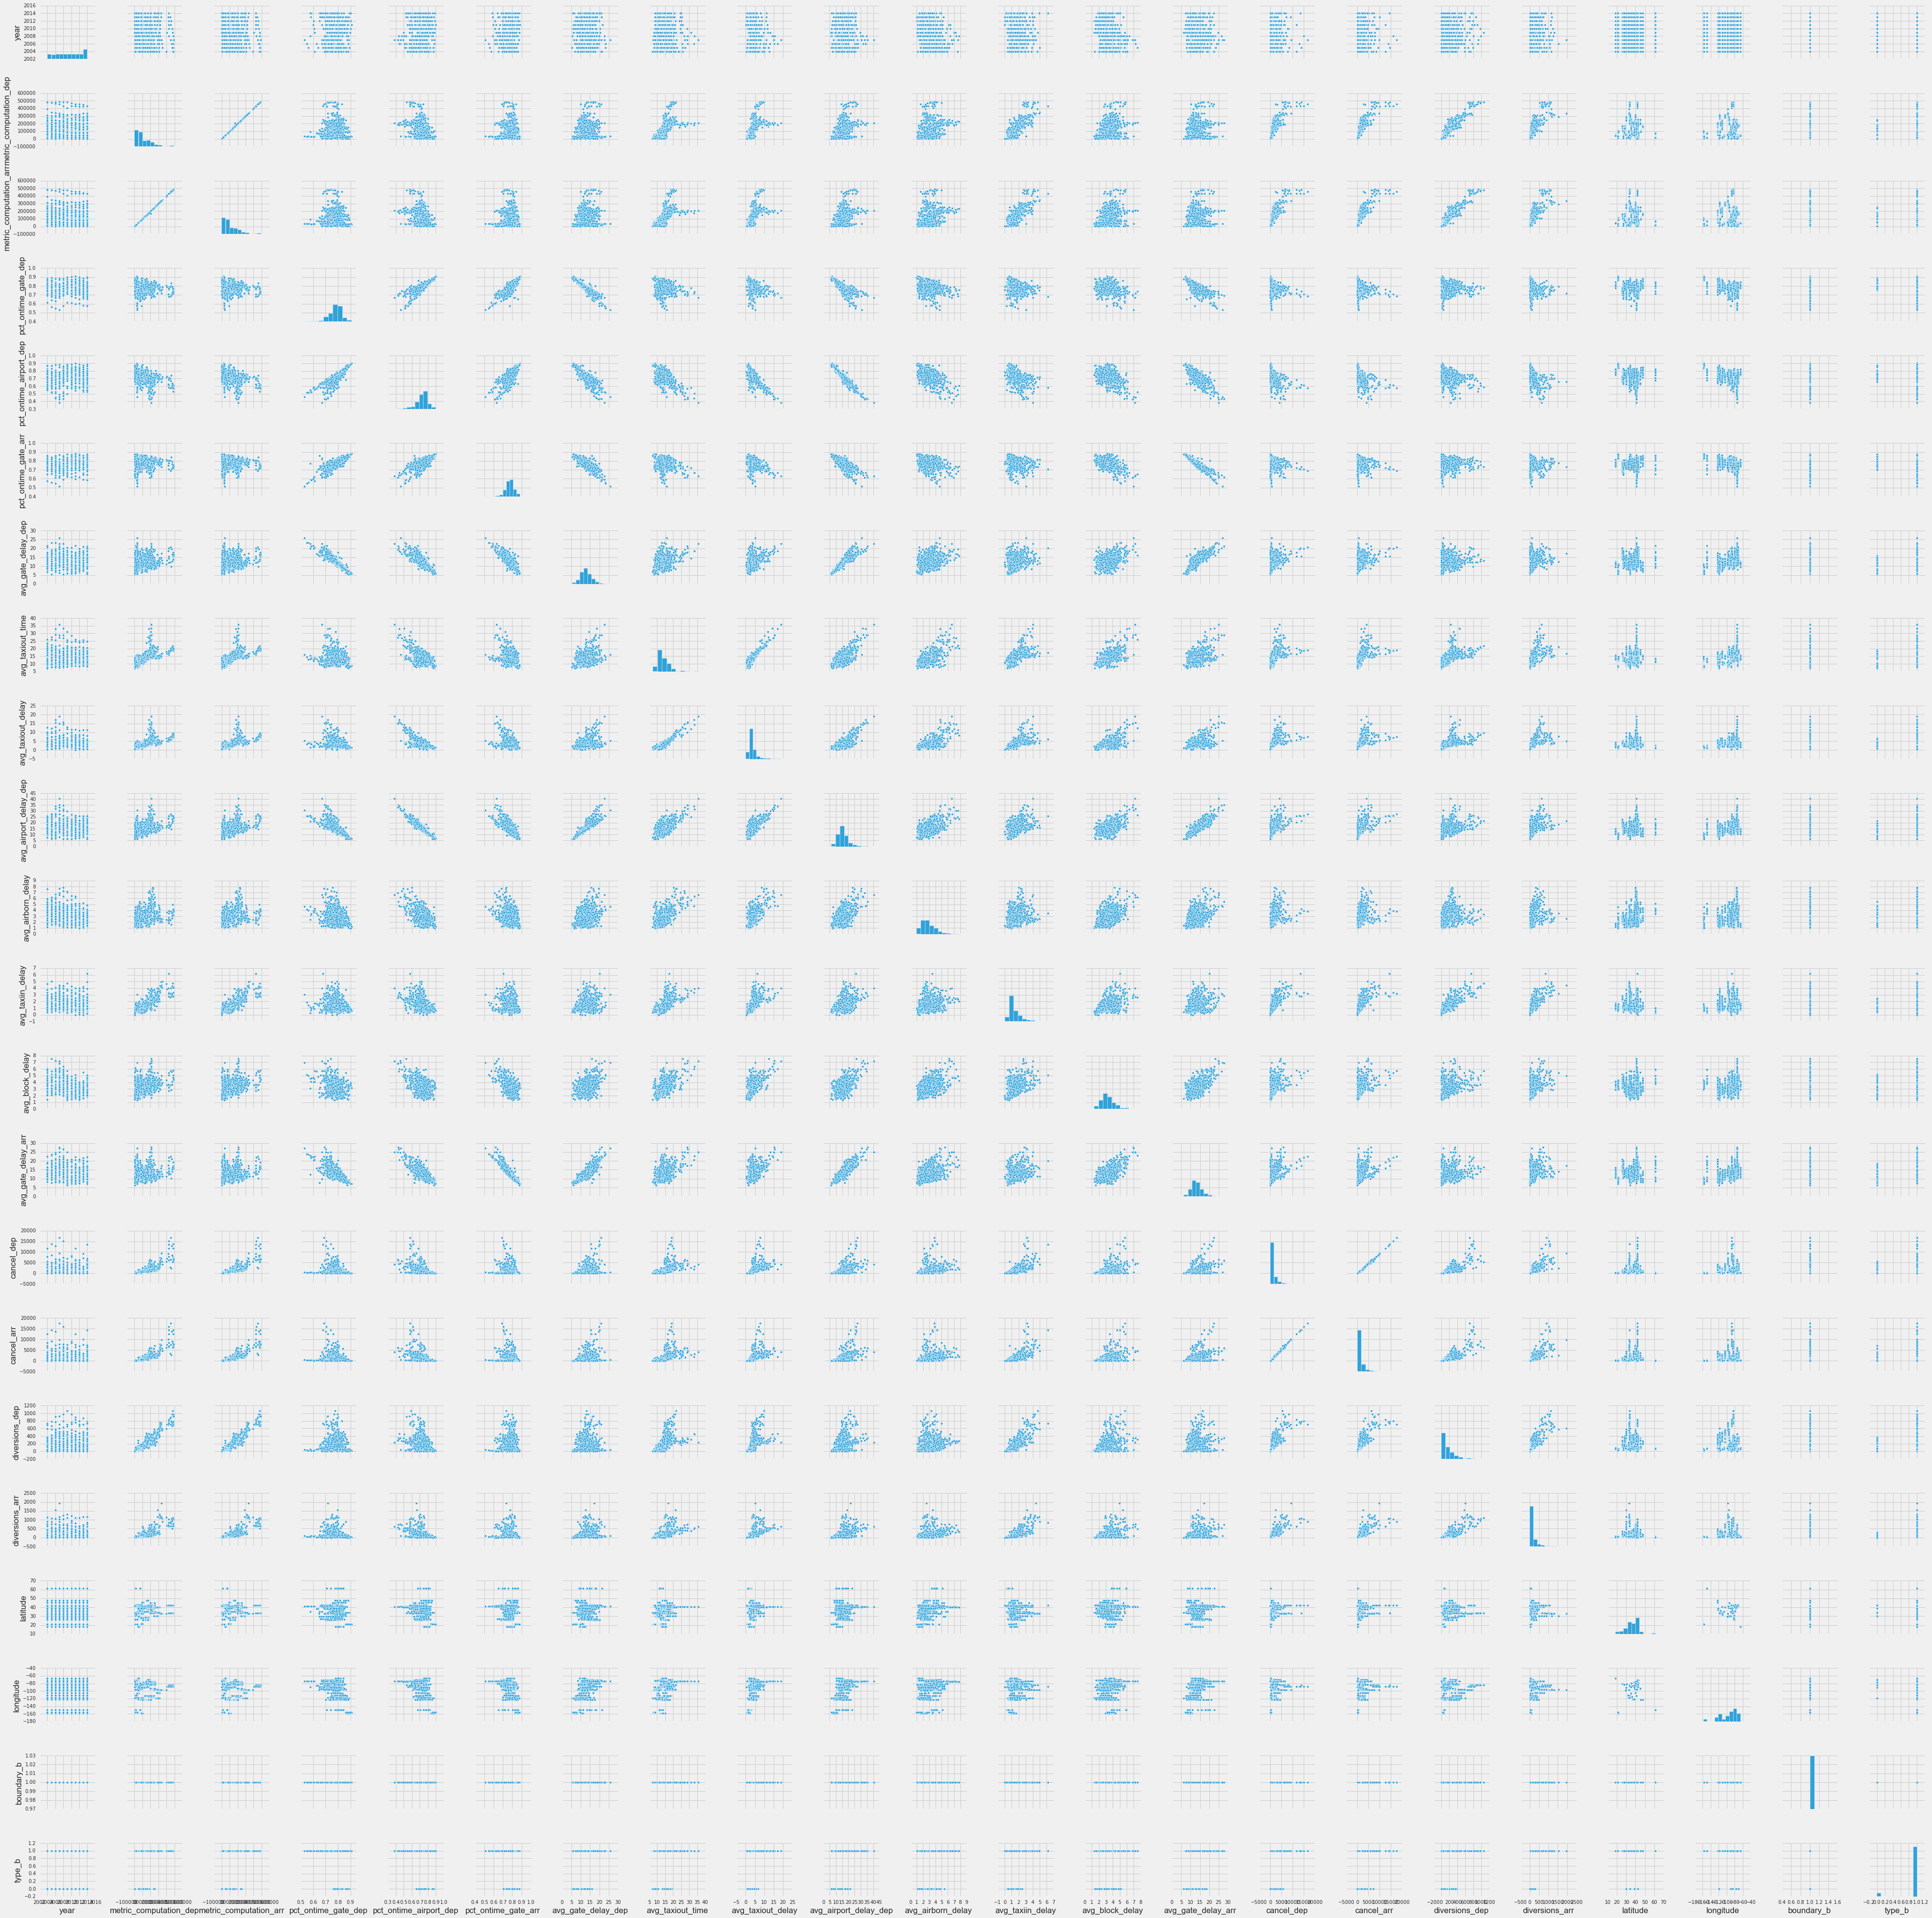

In [30]:
# quick look at all columns 
sns.pairplot(df)

In [12]:
# delete columns that will not be used in the analysis 
df1 = df.drop(['faa','county','city','state'],axis=1)

In [13]:
# save updated information
df.to_csv('airport_final.csv')

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120823190>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x123d49310>]], dtype=object)

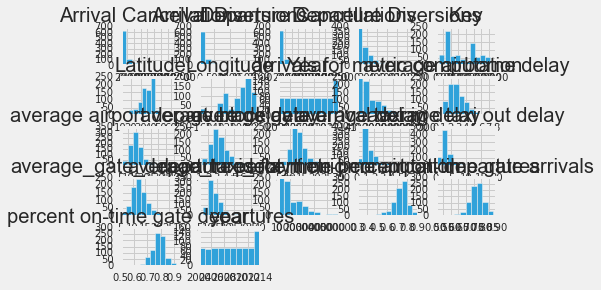

In [23]:
df.hist()

#### 4.2 Find correlations in the data

Most flight statistics are closely correlated in linear relationships. 

#### 4.3 What is the value of understanding correlations before PCA? 

The more correlation features are to each other; the better PCA will be able to sum up the data within a fewer principle components. 

#### 4.4 Validate your findings using statistical analysis

In [14]:
# import tools for PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [15]:
# set x and y
x = df1.ix[:,1:23].values
y = df1.ix[:,0].values

In [16]:
# scale x and y
xs = StandardScaler().fit_transform(x)

In [17]:
# print out the number of PCs 
for n in range(1, 22):
    pca = PCA(n_components = n).fit(xs)
    print str(n) + ' component(s): ' + str(sum(pca.explained_variance_ratio_))

1 component(s): 0.445676321051
2 component(s): 0.652482591052
3 component(s): 0.724206678762
4 component(s): 0.779592628195
5 component(s): 0.829089421593
6 component(s): 0.871724160804
7 component(s): 0.904251856753
8 component(s): 0.92772021862
9 component(s): 0.945772694982
10 component(s): 0.96051692697
11 component(s): 0.971921358675
12 component(s): 0.980214129111
13 component(s): 0.988022564266
14 component(s): 0.993780364747
15 component(s): 0.996614959418
16 component(s): 0.99903325433
17 component(s): 0.999682427578
18 component(s): 0.999871896858
19 component(s): 0.999947121875
20 component(s): 0.999991996676
21 component(s): 1.0


#### 4.5 How can you improve your overall analysis? 

We can see from a quick PCA analysis that after dimension reduction, six features can sum up 90% of the information that was given from 22 features. Using PCA will improve the performance of model training and make it more efficient. 

### Pre-PCA analysis 

In [115]:
# convert airport into numberic values 
airports = list(df1['airport'].unique())
airport_n = {y:x for x, y in enumerate(airports)}
df1['airport_n'] = df1['airport'].apply(lambda x: airport_n[x])
df1.head()

airport  year  metric_computation_dep  metric_computation_arr  \
0     ABQ  2004                   53971                   53818   
1     ABQ  2005                   51829                   51877   
2     ABQ  2006                   49682                   51199   
3     ABQ  2007                   53255                   53611   
4     ABQ  2008                   49589                   49512   

   pct_ontime_gate_dep  pct_ontime_airport_dep  pct_ontime_gate_arr  \
0               0.8030                  0.7809               0.7921   
1               0.8140                  0.7922               0.8001   
2               0.7983                  0.7756               0.7746   
3               0.8005                  0.7704               0.7647   
4               0.8103                  0.7844               0.7875   

   avg_gate_delay_dep  avg_taxiout_time  avg_taxiout_delay  ...    cancel_dep  \
0               10.38              9.89               2.43  ...         242.0   
1                9.60              9.79               2.29  ...         221.0   
2               10.84              9.89               2.16  ...         392.0   
3               11.29             10.34               2.40  ...         366.0   
4               10.79             10.41               2.41  ...         333.0   

   cancel_arr  diversions_dep  diversions_arr   latitude   longitude  \
0       235.0            71.0            46.0  35.040194 -106.609194   
1       190.0            61.0            33.0  35.040194 -106.609194   
2       329.0            71.0           124.0  35.040194 -106.609194   
3       304.0           107.0            45.0  35.040194 -106.609194   
4       300.0            79.0            42.0  35.040194 -106.609194   

   boundary_b  type_b  airport_n  label  
0           1       1          0      1  
1           1       1          0      1  
2           1       1          0      1  
3           1       1          0      1  
4           1       1          0      1  

[5 rows x 25 columns]

In [116]:
# set features and take a quick look
X = df1.iloc[:,1:23]
X.describe().T

count           mean           std          min  \
year                    799.0    2009.016270      3.150126  2004.000000   
metric_computation_dep  799.0  113471.568210  98059.144667   731.000000   
metric_computation_arr  799.0  113003.959950  97705.308115   717.000000   
pct_ontime_gate_dep     799.0       0.779123      0.052279     0.529900   
pct_ontime_airport_dep  799.0       0.726958      0.076027     0.380800   
pct_ontime_gate_arr     799.0       0.766864      0.050502     0.513600   
avg_gate_delay_dep      799.0      12.890250      3.036474     5.350000   
avg_taxiout_time        799.0      13.872879      3.806217     7.240000   
avg_taxiout_delay       799.0       3.683292      2.337325     0.100000   
avg_airport_delay_dep   799.0      15.703504      4.364217     6.290000   
avg_airborn_delay       799.0       2.875532      1.169739     0.950000   
avg_taxiin_delay        799.0       1.414155      0.854702     0.020000   
avg_block_delay         799.0       3.290826      0.989275     1.330000   
avg_gate_delay_arr      799.0      13.428811      3.251647     6.330000   
cancel_dep              799.0    1299.314143   1840.877193     0.000000   
cancel_arr              799.0    1341.068836   1980.459892     0.000000   
diversions_dep          799.0     174.250313    172.638408     0.000000   
diversions_arr          799.0     170.256571    229.162686     0.000000   
latitude                799.0      36.448807      6.686781    18.439295   
longitude               799.0     -94.899998     20.644996  -157.922429   
boundary_b              799.0       1.000000      0.000000     1.000000   
type_b                  799.0       0.936170      0.244603     0.000000   

                                 25%           50%            75%  \
year                     2006.000000   2009.000000    2012.000000   
metric_computation_dep  42064.000000  79489.000000  166469.500000   
metric_computation_arr  42006.500000  79750.000000  165560.500000   
pct_ontime_gate_dep         0.753100      0.784100       0.810700   
pct_ontime_airport_dep      0.691800      0.740200       0.773700   
pct_ontime_gate_arr         0.742150      0.770500       0.797600   
avg_gate_delay_dep         10.830000     12.540000      14.620000   
avg_taxiout_time           11.475000     12.940000      15.745000   
avg_taxiout_delay           2.300000      3.050000       4.220000   
avg_airport_delay_dep      12.890000     15.130000      17.555000   
avg_airborn_delay           2.035000      2.620000       3.550000   
avg_taxiin_delay            0.845000      1.140000       1.775000   
avg_block_delay             2.615000      3.130000       3.815000   
avg_gate_delay_arr         11.270000     12.970000      14.935000   
cancel_dep                349.000000    670.000000    1483.500000   
cancel_arr                314.500000    653.000000    1542.000000   
diversions_dep             62.000000    111.000000     237.000000   
diversions_arr             41.000000     84.000000     190.000000   
latitude                   32.896828     37.618972      40.795250   
longitude                -111.977773    -87.897068     -80.152741   
boundary_b                  1.000000      1.000000       1.000000   
type_b                      1.000000      1.000000       1.000000   

                                  max  
year                      2014.000000  
metric_computation_dep  491826.000000  
metric_computation_arr  486799.000000  
pct_ontime_gate_dep          0.909700  
pct_ontime_airport_dep       0.897400  
pct_ontime_gate_arr          0.880300  
avg_gate_delay_dep          25.840000  
avg_taxiout_time            35.760000  
avg_taxiout_delay           18.940000  
avg_airport_delay_dep       40.510000  
avg_airborn_delay            7.820000  
avg_taxiin_delay             6.180000  
avg_block_delay              7.520000  
avg_gate_delay_arr          27.780000  
cancel_dep               16618.000000  
cancel_arr               17571.000000  
diversions_dep            1064

In [117]:
# scale features
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

In [118]:
# implement k-means clustering 
from sklearn import cluster, metrics
s = []
i = []
for k in range(2, 10):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_

    s.append(metrics.silhouette_score(X, labels, metric='euclidean'))
    i.append(kmeans.inertia_)

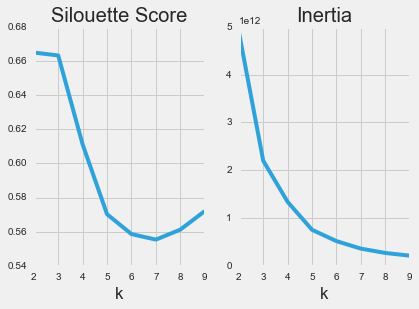

In [119]:
# plot and see the performance of the model when different clusters are defined
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(2,10), s)
ax1.set_title("Silouette Score")
ax1.set_xlabel("k")

ax2.plot(range(2,10), i)
ax2.set_title("Inertia")
ax2.set_xlabel("k")

# sns.despine()

In [126]:
# set the k-means model's clusters into 2 which optimize the model
k = 2
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
# assign labels of the cluster each record was in
df1['label'] = labels
metrics.silhouette_score(X, labels)

0.66489821202730548

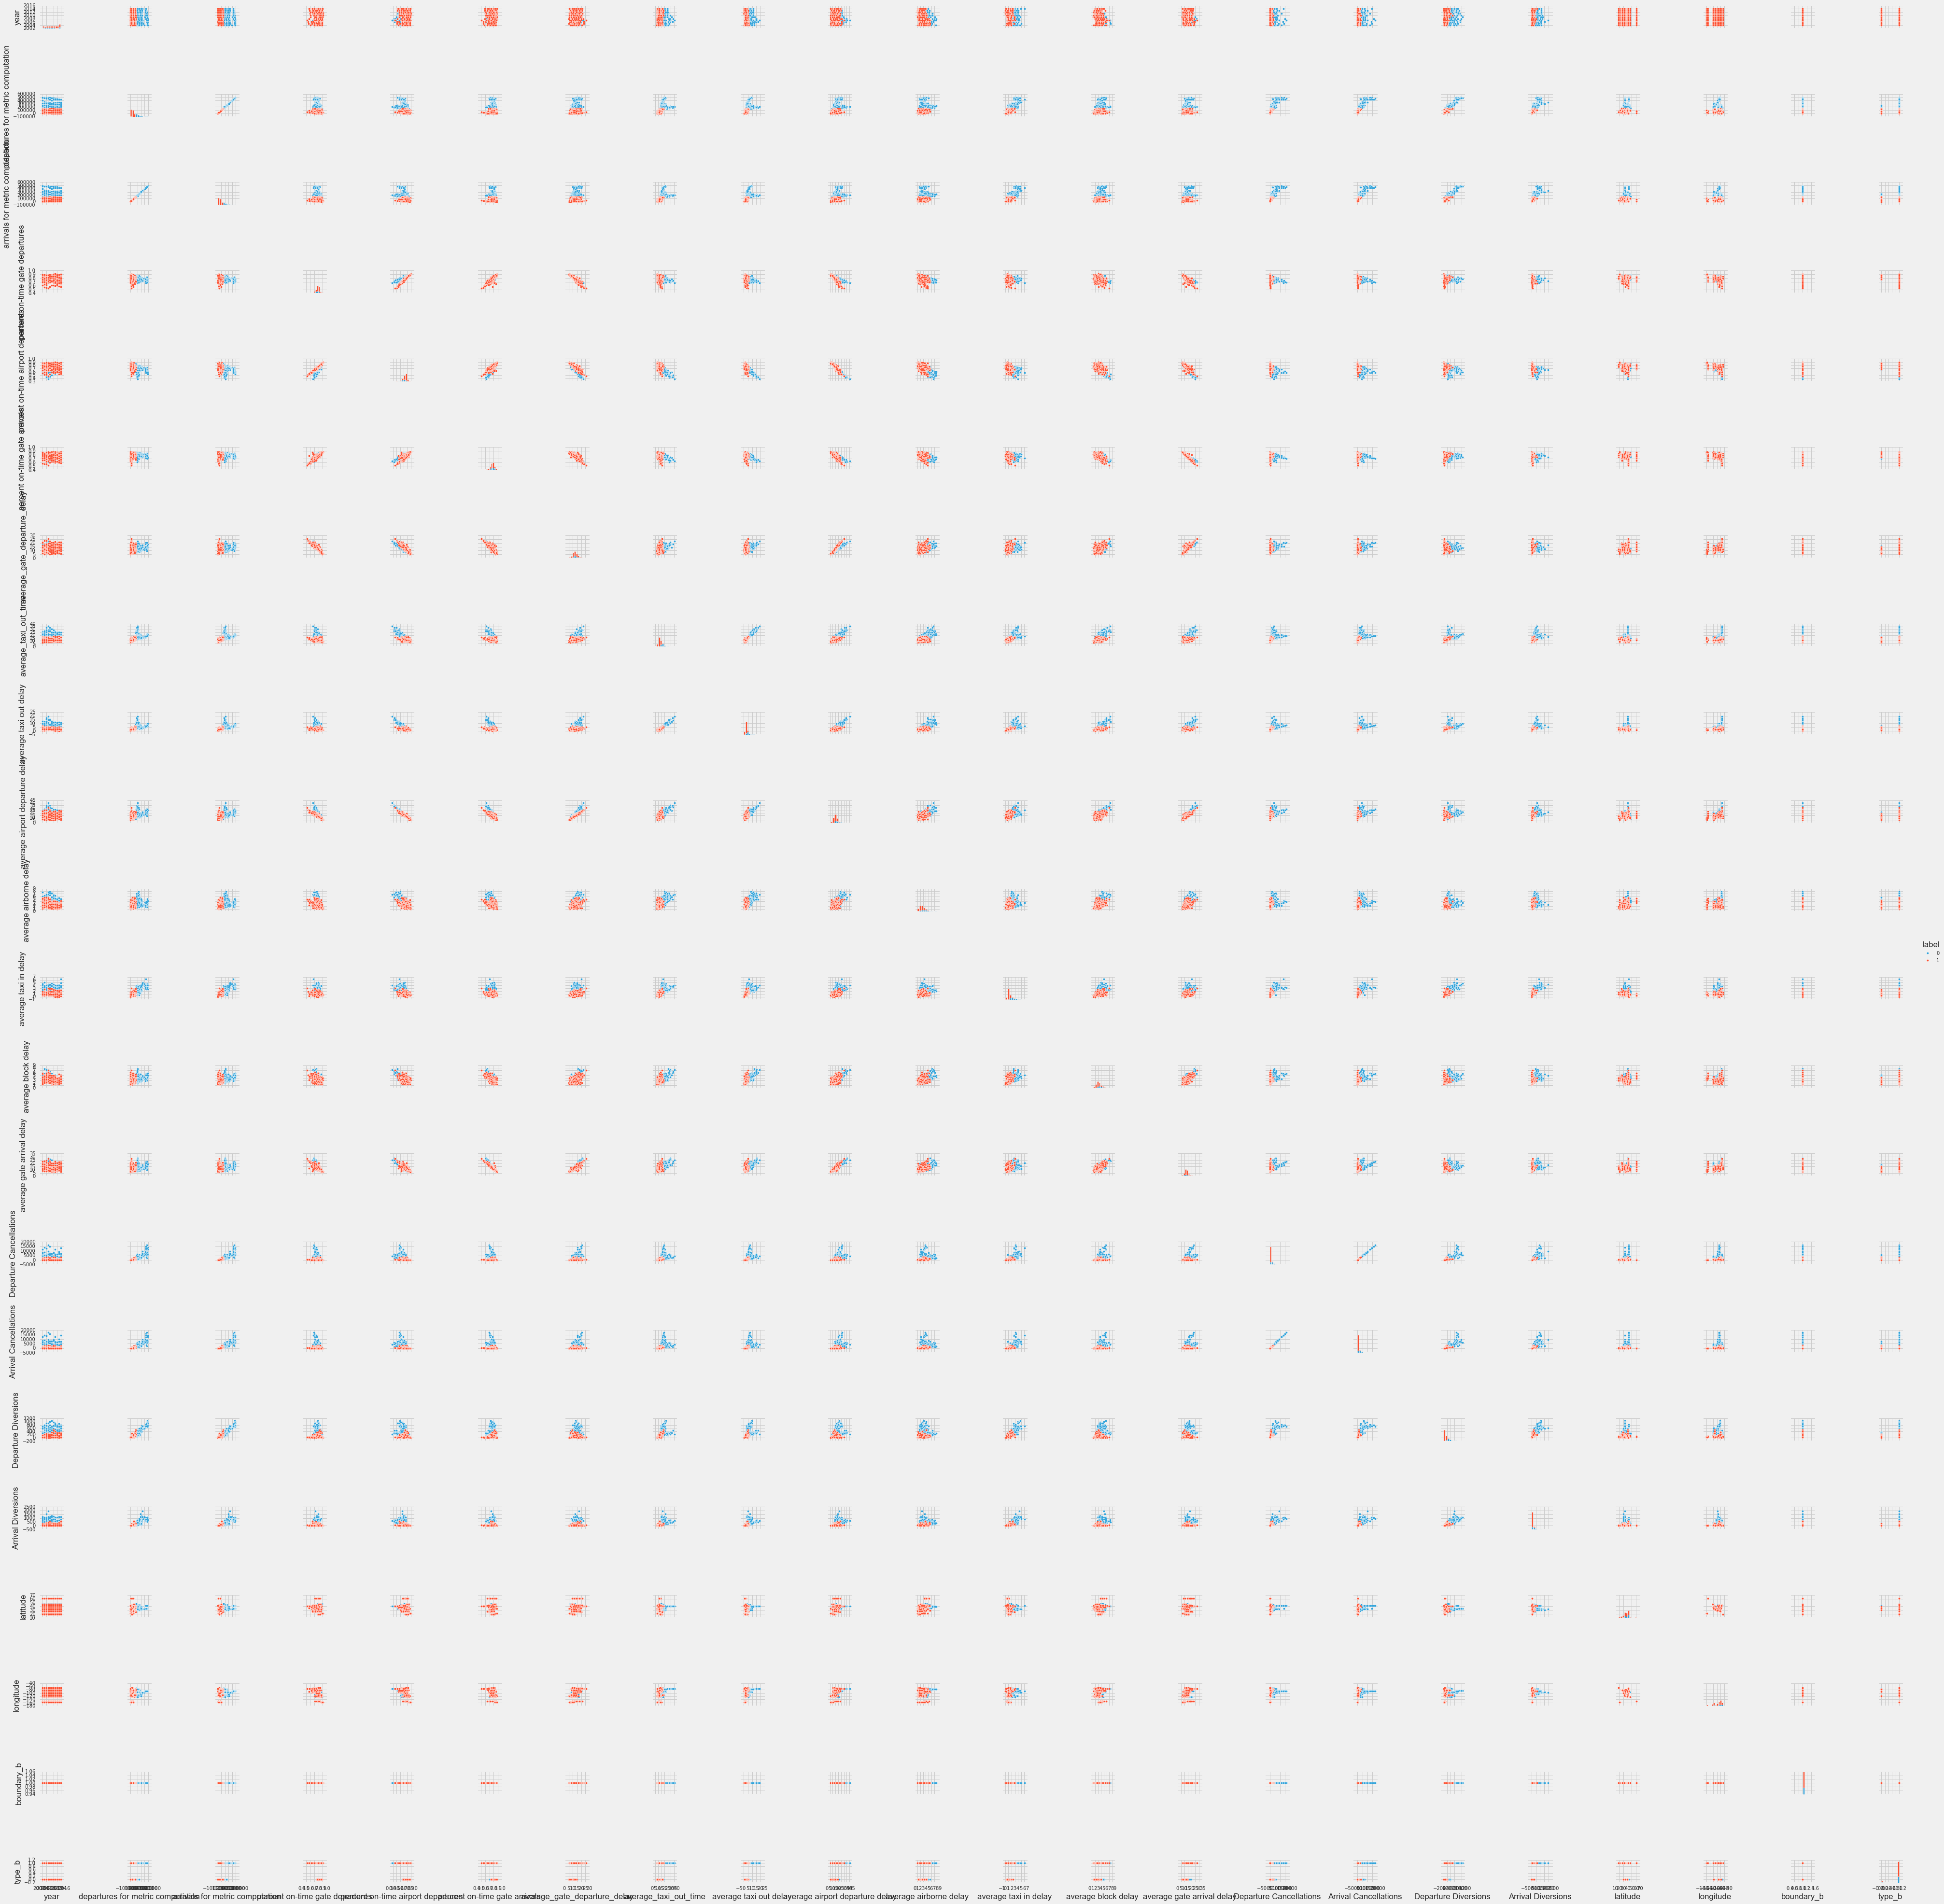

In [473]:
# quick look at how clusters seperate 
sns.pairplot(df1, hue='label', vars=X.columns)

In [121]:
# save it as csv for visualizing in R
df1.to_csv('airport_kmeans.csv')

In [122]:
# seperate 2 clusters into 2 different dataframes
dfc1 = df1[df1['label'] ==0]
dfc2 = df1[df1['label'] ==1]

In [124]:
# airports that are in cluster 1 
print dfc1.airport.unique()
dfc1.describe().T

['ABQ' 'ANC' 'AUS' 'BDL' 'BHM' 'BNA' 'BUF' 'BUR' 'BWI' 'CLE' 'CVG' 'DAL'
 'DAY' 'DCA' 'FLL' 'HNL' 'HOU' 'HPN' 'IAD' 'IND' 'ISP' 'JAX' 'LGB' 'MCI'
 'MCO' 'MDW' 'MEM' 'MHT' 'MIA' 'MKE' 'MSY' 'OAK' 'OGG' 'OMA' 'ONT' 'OXR'
 'PBI' 'PDX' 'PIT' 'PSP' 'PVD' 'RDU' 'RFD' 'RSW' 'SAN' 'SAT' 'SDF' 'SJC'
 'SJU' 'SLC' 'SMF' 'SNA' 'STL' 'SWF' 'TPA' 'TUS']


count          mean           std          min  \
year                    562.0   2009.147687      3.139292  2004.000000   
metric_computation_dep  562.0  60962.391459  35986.555678   731.000000   
metric_computation_arr  562.0  60754.597865  35828.473078   717.000000   
pct_ontime_gate_dep     562.0      0.780606      0.056428     0.529900   
pct_ontime_airport_dep  562.0      0.747744      0.062513     0.461200   
pct_ontime_gate_arr     562.0      0.765974      0.051325     0.513600   
avg_gate_delay_dep      562.0     12.659448      3.022397     5.350000   
avg_taxiout_time        562.0     12.107491      1.868190     7.240000   
avg_taxiout_delay       562.0      2.692509      0.880139     0.100000   
avg_airport_delay_dep   562.0     14.558826      3.389707     6.290000   
avg_airborn_delay       562.0      2.516085      0.875711     0.950000   
avg_taxiin_delay        562.0      1.016139      0.401581     0.020000   
avg_block_delay         562.0      3.045890      0.873831     1.330000   
avg_gate_delay_arr      562.0     13.106779      2.918996     6.330000   
cancel_dep              562.0    572.683274    469.841968     0.000000   
cancel_arr              562.0    543.225979    460.388769     0.000000   
diversions_dep          562.0     91.083630     63.831902     0.000000   
diversions_arr          562.0     79.343416     75.308430     0.000000   
latitude                562.0     35.848496      7.200473    18.439295   
longitude               562.0    -95.904509     21.939768  -157.922429   
boundary_b              562.0      1.000000      0.000000     1.000000   
type_b                  562.0      0.935943      0.245072     0.000000   
airport_n               562.0     37.585409     22.543300     0.000000   
label                   562.0      0.000000      0.000000     0.000000   

                                 25%           50%           75%  \
year                     2006.000000   2009.000000   2012.000000   
metric_computation_dep  34606.250000  54724.500000  85544.500000   
metric_computation_arr  34525.500000  54447.500000  85647.750000   
pct_ontime_gate_dep         0.755800      0.786950      0.814475   
pct_ontime_airport_dep      0.717900      0.753850      0.784775   
pct_ontime_gate_arr         0.743450      0.769800      0.794900   
avg_gate_delay_dep         10.720000     12.395000     14.337500   
avg_taxiout_time           10.940000     12.100000     13.077500   
avg_taxiout_delay           2.140000      2.520000      3.195000   
avg_airport_delay_dep      12.367500     14.410000     16.422500   
avg_airborn_delay           1.860000      2.390000      3.027500   
avg_taxiin_delay            0.760000      0.940000      1.190000   
avg_block_delay             2.460000      2.900000      3.480000   
avg_gate_delay_arr         11.270000     12.795000     14.577500   
cancel_dep                263.000000    444.500000    752.750000   
cancel_arr                240.250000    412.500000    720.250000   
diversions_dep             48.000000     78.000000    119.750000   
diversions_arr             32.000000     54.000000    101.500000   
latitude                   30.899563     36.743569     40.795250   
longitude                -116.506694    -87.752417    -80.152741   
boundary_b                  1.000000      1.000000      1.000000   
type_b                      1.000000      1.000000      1.000000   
airport_n                  16.000000     39.000000     57.000000   
label                       0.000000      0.000000      0.000000   

                                  max  
year                      2014.000000  
metric_computation_dep  153661.000000  
metric_computation_arr  148527.000000  
pct_ontime_gate_dep          0.909700  
pct_ontime_airport_dep       0.897400  
pct_ontime_gate_arr          0.880300  
avg_gate_delay_dep          25.840000  
avg_taxiout_time            18.290000  
avg_taxiout_delay            6.180000  
avg_airport_delay_dep       30.620000  
avg_airborn_delay            5.5

In [125]:
# airports that are in cluster 2 
print dfc2.airport.unique()
dfc2.describe().T

['ATL' 'BOS' 'CLT' 'CVG' 'DEN' 'DFW' 'DTW' 'EWR' 'IAD' 'IAH' 'JFK' 'LAS'
 'LAX' 'LGA' 'MCO' 'MEM' 'MIA' 'MSP' 'ORD' 'PHL' 'PHX' 'PIT' 'SEA' 'SFO'
 'SLC']


count           mean           std            min  \
year                    237.0    2008.704641      3.160485    2004.000000   
metric_computation_dep  237.0  237987.000000  85437.765588  150156.000000   
metric_computation_arr  237.0  236903.291139  85503.736407  144138.000000   
pct_ontime_gate_dep     237.0       0.775605      0.040681       0.668800   
pct_ontime_airport_dep  237.0       0.677666      0.082378       0.380800   
pct_ontime_gate_arr     237.0       0.768975      0.048535       0.610900   
avg_gate_delay_dep      237.0      13.437553      3.005717       6.940000   
avg_taxiout_time        237.0      18.059156      3.958449      12.950000   
avg_taxiout_delay       237.0       6.032743      2.958083       2.390000   
avg_airport_delay_dep   237.0      18.417890      5.154600       8.650000   
avg_airborn_delay       237.0       3.727890      1.329083       1.290000   
avg_taxiin_delay        237.0       2.357975      0.902755       0.650000   
avg_block_delay         237.0       3.871646      1.006202       1.740000   
avg_gate_delay_arr      237.0      14.192447      3.829475       8.020000   
cancel_dep              237.0    3022.379747   2587.510537     423.000000   
cancel_arr              237.0    3233.000000   2765.528406     441.000000   
diversions_dep          237.0     371.464135    188.582052      87.000000   
diversions_arr          237.0     385.839662    312.628915      35.000000   
latitude                237.0      37.872329      5.005150      25.795361   
longitude               237.0     -92.517994     16.995661    -122.374889   
boundary_b              237.0       1.000000      0.000000       1.000000   
type_b                  237.0       0.936709      0.244001       0.000000   
airport_n               237.0      32.628692     17.842689       2.000000   
label                   237.0       1.000000      0.000000       1.000000   

                                  25%            50%            75%  \
year                      2006.000000    2009.000000    2011.000000   
metric_computation_dep  177409.000000  208700.000000  262782.000000   
metric_computation_arr  175080.000000  208196.000000  262066.000000   
pct_ontime_gate_dep          0.747700       0.777500       0.801300   
pct_ontime_airport_dep       0.637100       0.696200       0.732300   
pct_ontime_gate_arr          0.739000       0.775700       0.806600   
avg_gate_delay_dep          11.600000      12.870000      15.500000   
avg_taxiout_time            15.530000      17.160000      19.300000   
avg_taxiout_delay            3.990000       5.180000       7.040000   
avg_airport_delay_dep       14.950000      17.300000      21.140000   
avg_airborn_delay            2.660000       3.650000       4.430000   
avg_taxiin_delay             1.770000       2.230000       2.800000   
avg_block_delay              3.180000       3.670000       4.400000   
avg_gate_delay_arr          11.270000      13.390000      16.540000   
cancel_dep                1458.000000    2206.000000    3744.000000   
cancel_arr                1593.000000    2380.000000    3849.000000   
diversions_dep             247.000000     307.000000     442.000000   
diversions_arr             174.000000     260.000000     491.000000   
latitude                    33.942496      39.048837      40.788388   
longitude                 -111.977773     -87.906671     -77.459944   
boundary_b                   1.000000       1.000000       1.000000   
type_b                       1.000000       1.000000       1.000000   
airport_n                   19.000000      31.000000      48.000000   
label                        1.000000       1.000000       1.000000   

                                  max  
year                      2014.000000  
metric_computation_dep  491826.000000  
metric_computation_arr  486799.000000  
pct_ontime_gate_dep          0.880600  
pct_ontime_airport_dep       0.850700  
pct_ontime_gate_arr          0.857700  
avg_gate_delay_dep          22.680000  
av

In [46]:
# check if the cluster is related to regions (compared to graphs generated in R )
k = 9
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
df1['label'] = labels
import sklearn.metrics
metrics.silhouette_score(X, labels)

0.56963882987055658

## H Clustering 

In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
X1 = X.as_matrix(columns=None)
Z = linkage(X1, 'complete')
c, coph_dists = cophenet(Z, pdist(X1))
c

0.78213315745183909

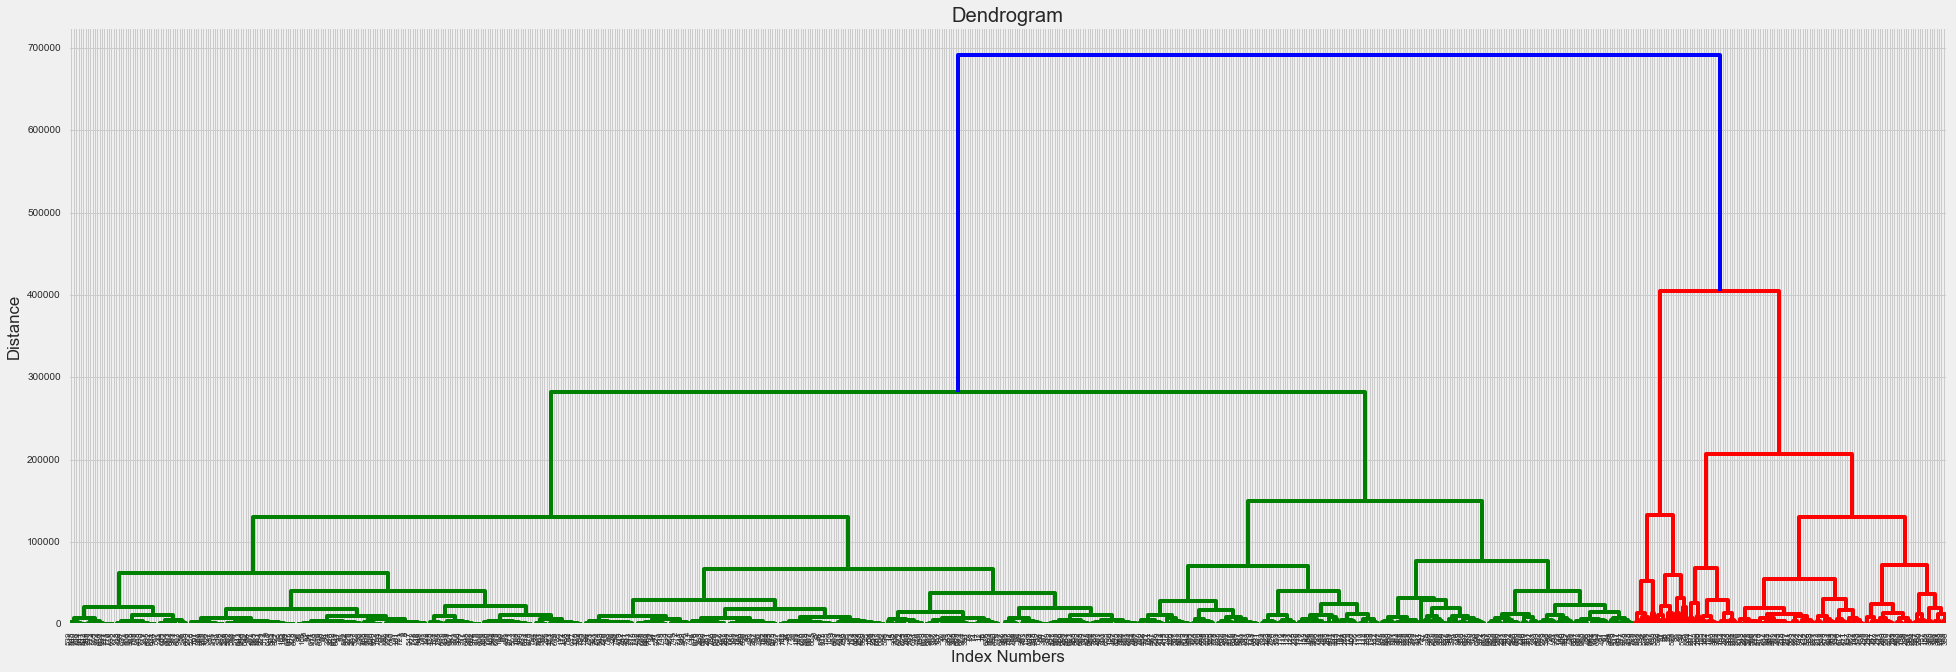

In [52]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

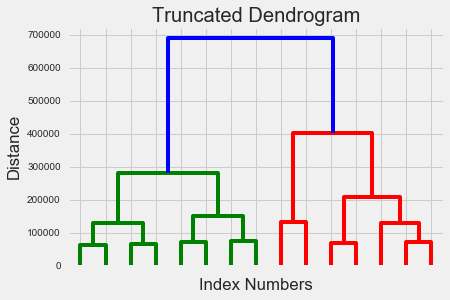

In [53]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [58]:
clusters = fcluster(Z, 20, criterion='distance')
# metrics.silhouette_score(X1, clusters)

### Part 5: Perform a PCA

#### 5.1 Conduct the PCA

In [127]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [128]:
# set x and y
x = df1.ix[:,1:23].values
y = df1.ix[:,0].values

In [129]:
# scale x
xStand = StandardScaler().fit_transform(x)

In [130]:
# conduct PCA
pcask = PCA(n_components=2)
print pcask.fit(xStand).components_ # See the eigenvectors
xPC = pcask.fit_transform(xStand) # Use the eigenvectors to transform xStand onto new axes
pcask.explained_variance_ratio_

[[ 0.04008749 -0.24966734 -0.24936308  0.16953286  0.27466551  0.15476924
  -0.20578771 -0.26650941 -0.27263165 -0.28177187 -0.20316894 -0.25872317
  -0.21961525 -0.21493804 -0.26250296 -0.26058038 -0.23939247 -0.24577332
  -0.06893089 -0.12803476  0.         -0.01816209]
 [-0.00637718 -0.27830365 -0.27887695 -0.3320802  -0.21021218 -0.38108176
   0.32307143 -0.05015841 -0.03240061  0.21642142  0.04593833 -0.18941344
   0.09461248  0.31337192 -0.18653787 -0.19741103 -0.27701904 -0.2150709
   0.07593472  0.19751491  0.          0.0598604 ]]


array([ 0.44567632,  0.20680627])

In [131]:
# create new dataframe to graph
PCdf = pd.DataFrame(xPC, columns=['PC1','PC2'])
airport_pca = df1[['airport', 'year']].join(PCdf, on=None, how='left')

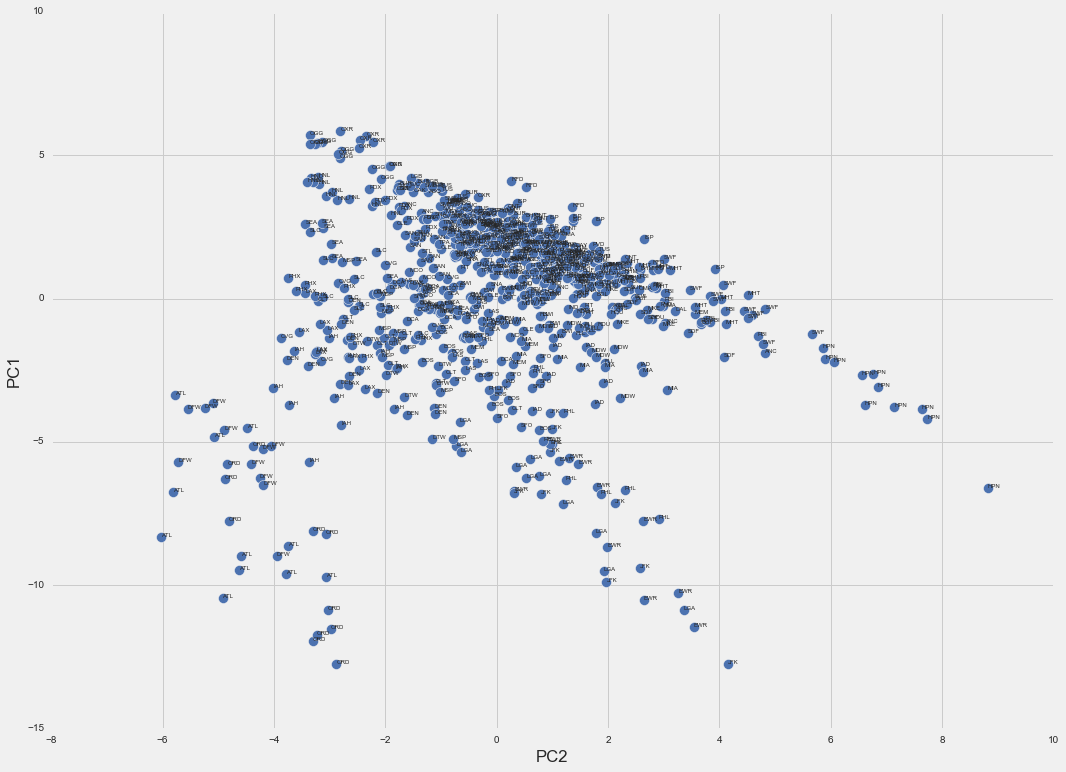

In [132]:
# scatter plot of PC1 and PC2 
graph = airport_pca.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,12), s=100)

for i, airport in enumerate(airport_pca['airport']):
    graph.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1), fontsize=6)

In [133]:
# conduct k-means again after PCA
xpc = PCdf

In [134]:
# create 2 clusters 
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(xpc)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [135]:
# print out the silouette score of the model 
metrics.silhouette_score(xpc, labels, metric='euclidean')

0.50769181022765242

In [80]:
# assign k-means cluster to data 
airport_pca['cluster'] = labels
c = airport_pca['cluster'].map(lambda x: 'b' if x == 1 else 'r')

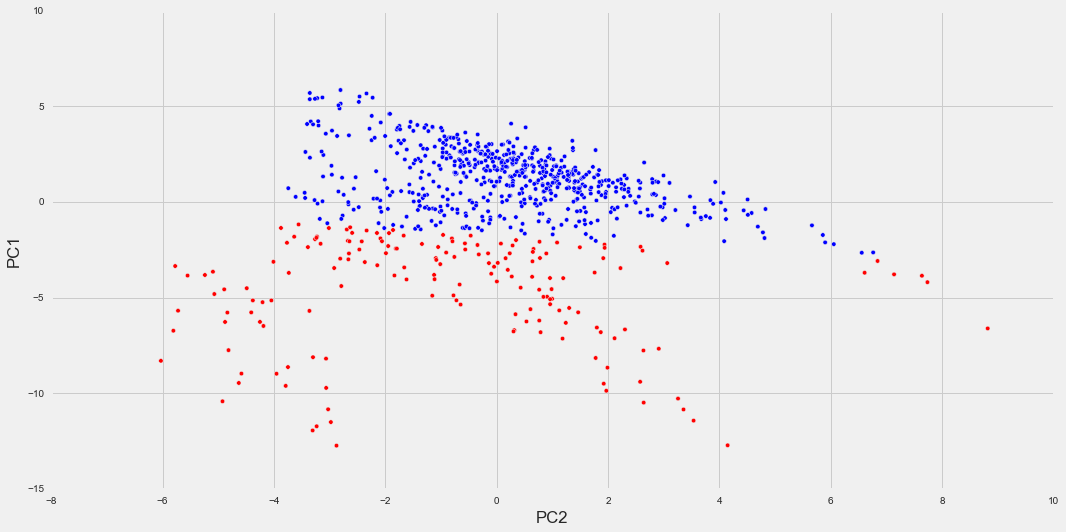

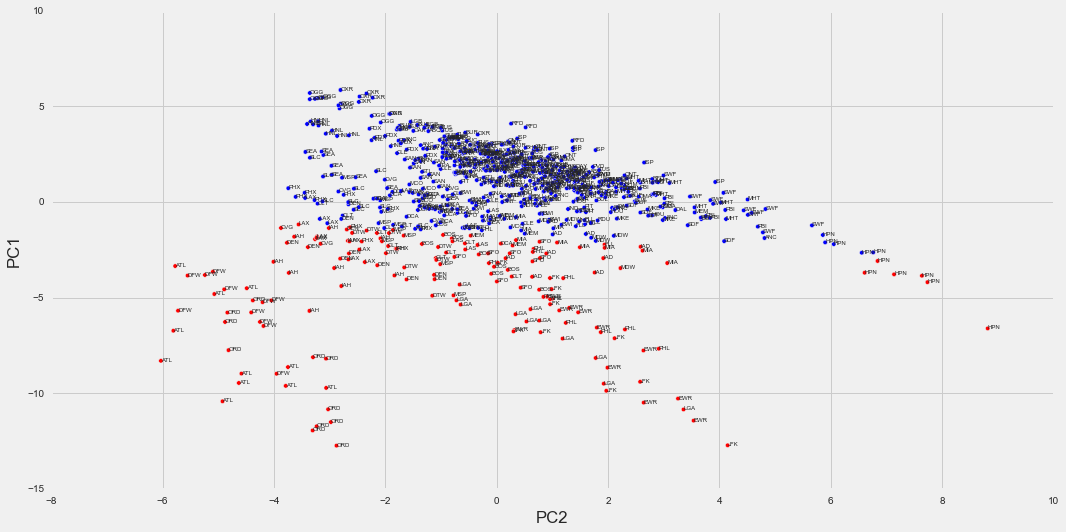

In [81]:
c = airport_pca['cluster'].map(lambda x: 'b' if x == 1 else 'r')
airport_pca.plot(kind='scatter',x='PC2',y='PC1',c= c, figsize=(16,8))

graph2 = airport_pca.plot(kind='scatter', x='PC2',y='PC1', c = c, figsize=(16,8))

for i, airport in enumerate(airport_pca['airport']):
    graph2.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1), fontsize=6)
    

In [82]:
airport_pca['avg_gate_delay_dep'] = X['avg_gate_delay_dep']
airport_pca['cancel_dep'] = X['cancel_dep']

In [83]:
airport_pca.to_csv('airport_pca.csv')

In [84]:
pcask = PCA(n_components=3)
print pcask.fit(xStand).components_ # See the eigenvectors
xPC = pcask.fit_transform(xStand) # Use the eigenvectors to transform xStand onto new axes
pcask.explained_variance_ratio_
PCdf = pd.DataFrame(xPC, columns=['PC1','PC2','PC3'])
airport_pca = df1[['airport', 'year']].join(PCdf, on=None, how='left')

[[ 0.04008749 -0.24966734 -0.24936308  0.16953286  0.27466551  0.15476924
  -0.20578771 -0.26650941 -0.27263165 -0.28177187 -0.20316894 -0.25872317
  -0.21961525 -0.21493804 -0.26250296 -0.26058038 -0.23939247 -0.24577332
  -0.06893089 -0.12803476  0.         -0.01816209]
 [-0.00637718 -0.27830365 -0.27887695 -0.3320802  -0.21021218 -0.38108176
   0.32307143 -0.05015841 -0.03240061  0.21642142  0.04593833 -0.18941344
   0.09461248  0.31337192 -0.18653787 -0.19741103 -0.27701904 -0.2150709
   0.07593472  0.19751491  0.          0.0598604 ]
 [-0.52491705 -0.06037509 -0.06199314  0.24674904  0.04136893  0.03835403
  -0.22334985  0.21663762  0.24604629 -0.04549095  0.47119506 -0.0979358
   0.26672377 -0.03177539 -0.1029751  -0.10938938 -0.1487712  -0.15180303
   0.26122736 -0.03867284  0.         -0.22854179]]


In [85]:
metrics.silhouette_score(xpc, labels, metric='euclidean')

0.50769181022765242

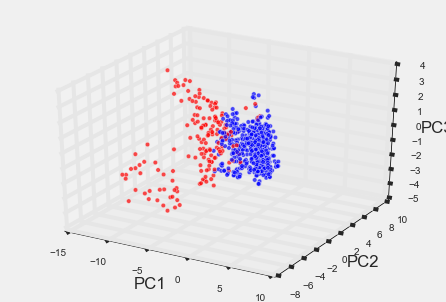

In [86]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(airport_pca['PC1'], airport_pca['PC2'],airport_pca['PC3'], zdir='z',c=c,cmap='prism', alpha=.7, depthshade=True)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

In [87]:
# set x and y 
x = df1.iloc[:,1:23]
y = df1.iloc[:,23]

In [89]:
# split data into train and test sets 
from sklearn.cross_validation import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=3)

# print out the size of train and test sets 
print "Train", x_train.shape, y_train.shape
print "Test ", x_test.shape, y_test.shape

Train (399, 22) (399,)
Test  (400, 22) (400,)


In [90]:
from sklearn import linear_model
lr = linear_model.LogisticRegression()
result = lr.fit(x_train, y_train)

print "Score:", result.score(x_test, y_test) 

Score: 0.615


In [91]:
# generate the classification report
from sklearn.metrics import confusion_matrix
predictions = result.predict(x_test)
cm = confusion_matrix(y_test, predictions)
print cm

[[5 0 0 ..., 0 0 0]
 [0 4 0 ..., 0 0 0]
 [0 0 4 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 6 0 0]
 [0 0 0 ..., 0 2 0]
 [4 0 0 ..., 0 0 1]]


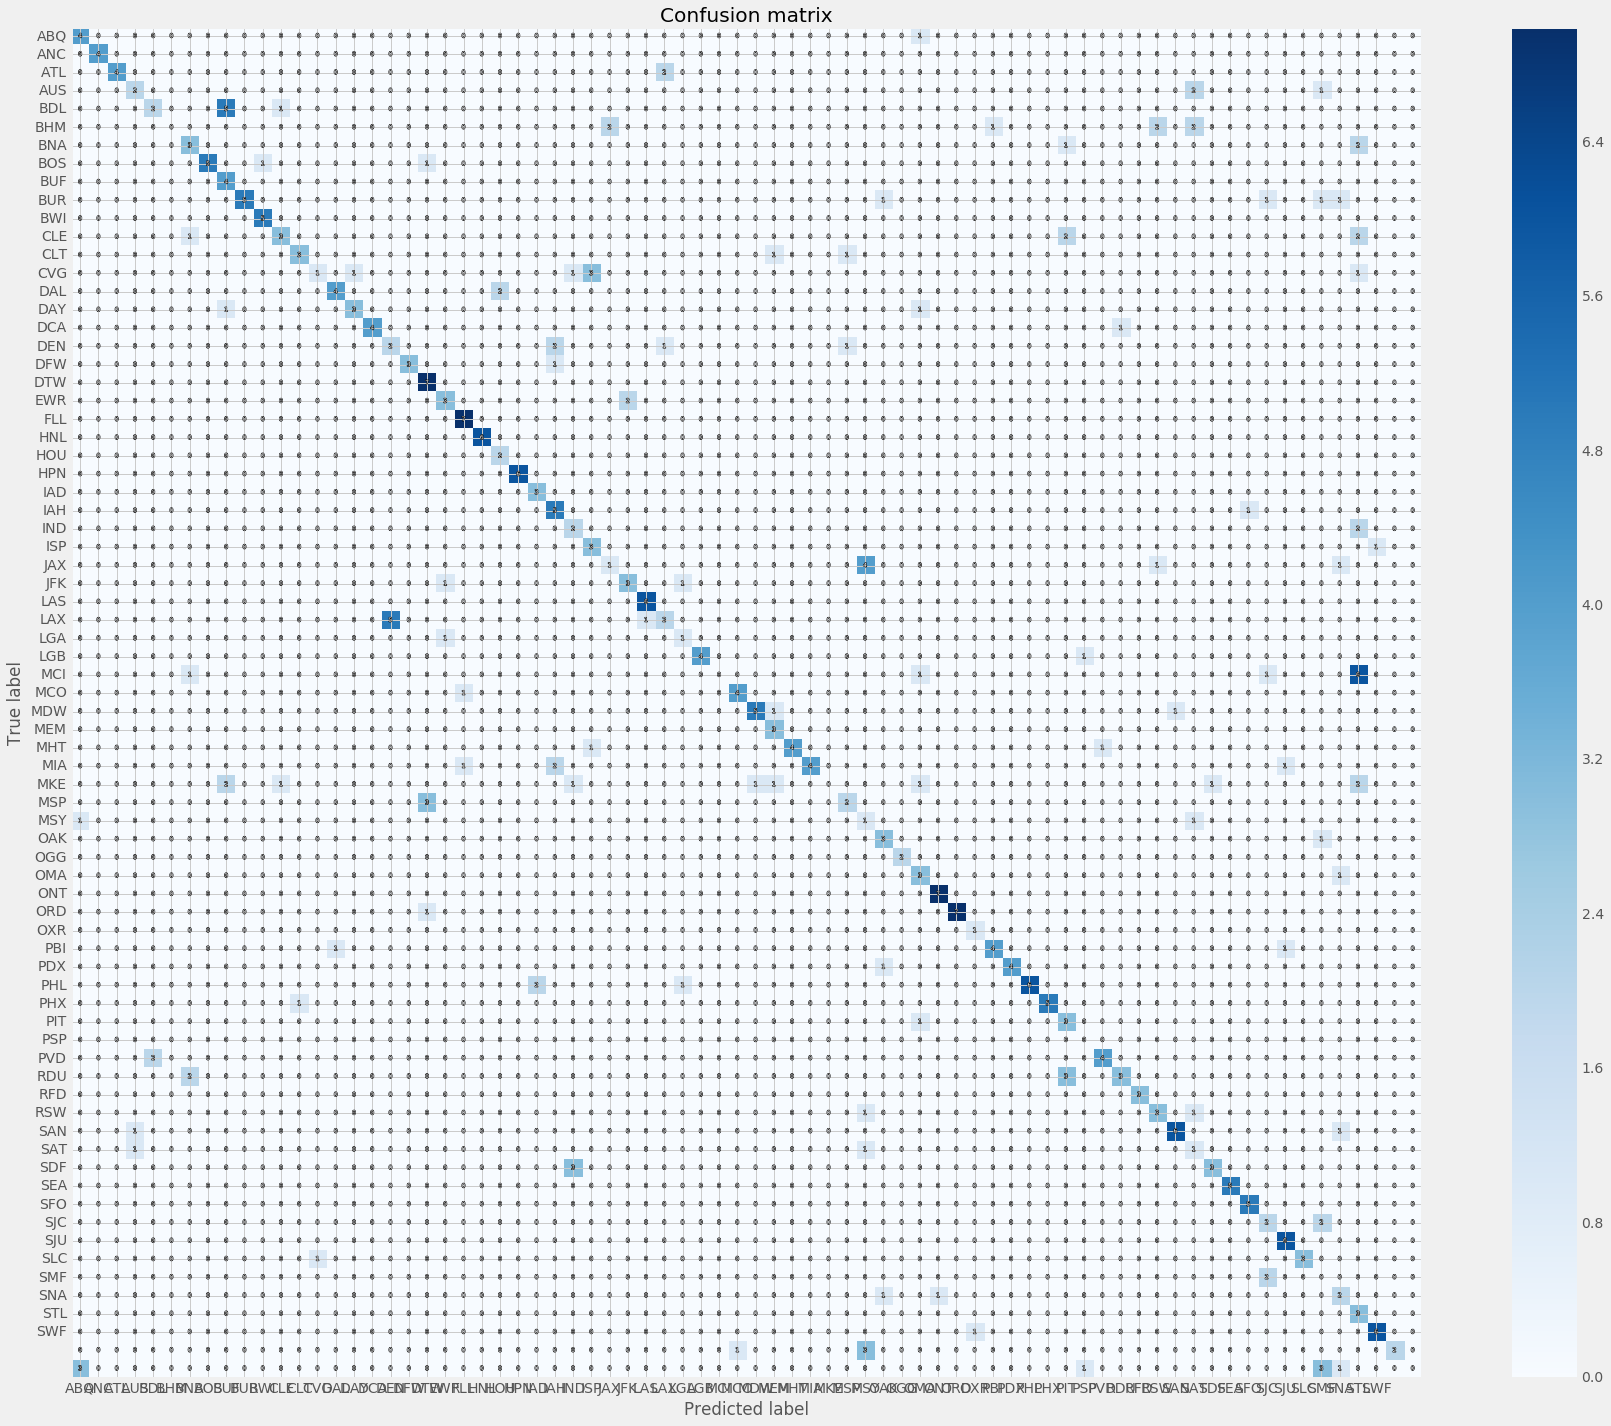

In [205]:
# create a function that plot the confusion matrix 
import matplotlib.patheffects as path_effects
# function that plots confusion matrix

def plot_confusion_matrix(cm, title='Confusion matrix', labels = [1,2,3], cmap=plt.cm.Blues, t_number =2):
    
    plt.figure(figsize=(25,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(t_number)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=6).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline
# plot confusion matrix
plot_confusion_matrix(cm,labels = airports, title='Confusion matrix', cmap=plt.cm.Blues,t_number =72)

## Trees

In [93]:
# set x and y for the model 
xc = X.drop(['cancel_dep','cancel_arr'],axis=1)
yc = X.cancel_dep.apply(lambda x: 1 if x >= np.mean(X.cancel_dep) else 0)

In [94]:
# train and test for tree models that predict cancel 
from sklearn.cross_validation import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(xc, yc, test_size=0.5, random_state=3)

from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

# try other ensemble methods (random forest=, extra tree, adaboost, gradient boosting)
rfdt = RandomForestClassifier(random_state=3)
etdt = ExtraTreesClassifier(random_state=3)
abdt = AdaBoostClassifier(random_state=3)
gbdt = GradientBoostingClassifier(random_state=3)

# apply those models to the train set 
result_rfdt = rfdt.fit(x_train,y_train)
result_etdt = etdt.fit(x_train,y_train)
result_abdt = abdt.fit(x_train,y_train)
result_gbdt = gbdt.fit(x_train,y_train)

# print out the accuracy scores 
print "Random Forest Accuracy Score: " + str(result_rfdt.score(x_test,y_test))
print "Extra Tree Accuracy Score: " + str(result_etdt.score(x_test,y_test))
print "Ada Boost Accuracy Score: " + str(result_abdt.score(x_test,y_test))
print "Gradient Boosting Accuracy Score: " + str(result_gbdt.score(x_test,y_test))

Random Forest Accuracy Score: 0.9125
Extra Tree Accuracy Score: 0.92
Ada Boost Accuracy Score: 0.93
Gradient Boosting Accuracy Score: 0.9375


In [95]:
# create the confusion matrix
from sklearn.metrics import confusion_matrix
predictions = result_gbdt.predict(x_test)
cm = confusion_matrix(y_test, predictions)
print cm

[[274  14]
 [ 11 101]]


In [96]:
# create a function that plot the confusion matrix 
import matplotlib.patheffects as path_effects
# function that plots confusion matrix

def plot_confusion_matrix(cm, title='Confusion matrix', labels= [1,2,3], cmap=plt.cm.Blues, t_number =2):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(t_number)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

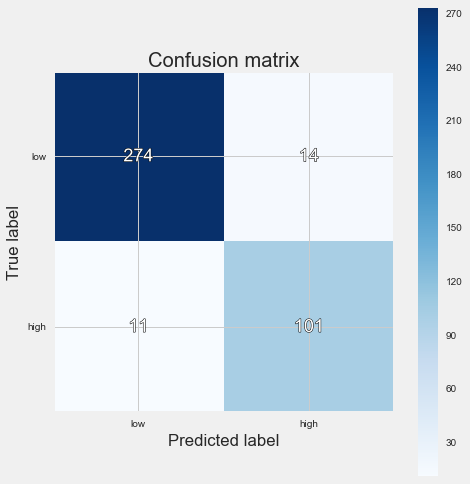

In [97]:
# plot confusion matrix
import numpy as np
plot_confusion_matrix(cm,labels = ['low','high'],title='Confusion matrix', cmap=plt.cm.Blues,t_number =2)

/Users/Lydia/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:4: DeprecationWarning: sklearn.metrics.metrics is deprecated and will be removed in 0.18. Please import from sklearn.metrics
  DeprecationWarning)


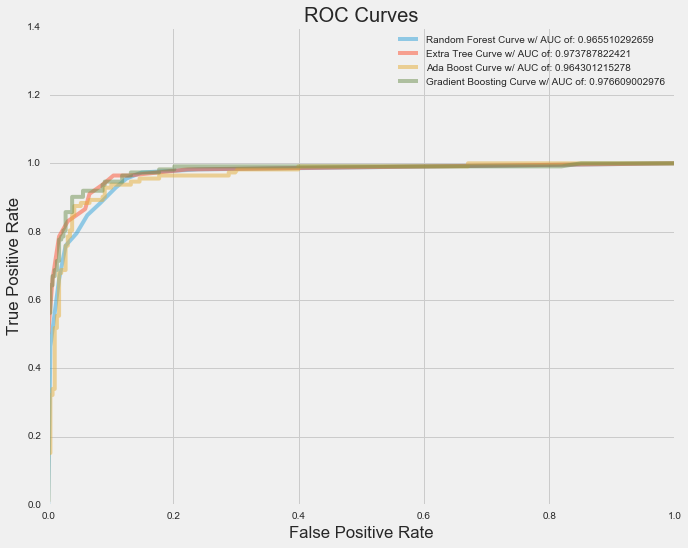

In [98]:
# get the ROC curves for all above and plot 
from sklearn.metrics import roc_curve, metrics
roc_rfdt = roc_curve(y_test, result_rfdt.predict_proba(x_test).T[1])
roc_etdt = roc_curve(y_test, result_etdt.predict_proba(x_test).T[1])
roc_abdt = roc_curve(y_test, result_abdt.predict_proba(x_test).T[1])
roc_gbdt = roc_curve(y_test, result_gbdt.predict_proba(x_test).T[1])



fpr7, tpr7, thresholds = roc_rfdt
fpr8, tpr8, thresholds = roc_etdt
fpr9, tpr9, thresholds = roc_abdt
fpr10, tpr10, thresholds = roc_gbdt

fig,ax = plt.subplots(figsize = (10,8))

auc7 = metrics.auc(fpr7,tpr7)
auc8 = metrics.auc(fpr8,tpr8)
auc9 = metrics.auc(fpr9,tpr9)
auc10 = metrics.auc(fpr10,tpr10)

ax.plot(fpr7, tpr7, label='Random Forest Curve w/ AUC of: ' + str(auc7), alpha = 0.5)
ax.plot(fpr8, tpr8, label='Extra Tree Curve w/ AUC of: ' + str(auc8), alpha = 0.5)
ax.plot(fpr9, tpr9, label='Ada Boost Curve w/ AUC of: ' + str(auc9), alpha = 0.5)
ax.plot(fpr10, tpr10, label='Gradient Boosting Curve w/ AUC of: ' + str(auc10), alpha = 0.5)


plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis([0,1,0,1.4])
plt.legend()

In [99]:
# check the feature importance of the best model 
feature_importances = pd.DataFrame(gbdt.feature_importances_,
                                   index = xc.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print 'Gradient Boosting (Cancellations):'
feature_importances.head(10)

Gradient Boosting (Cancellations):


importance
diversions_arr            0.156763
metric_computation_arr    0.141477
metric_computation_dep    0.119679
avg_airborn_delay         0.085690
diversions_dep            0.081862
avg_gate_delay_arr        0.052286
latitude                  0.051142
avg_airport_delay_dep     0.045633
avg_taxiout_time          0.043916
avg_taxiout_delay         0.042191

## diversions 

In [101]:
# set x and y for predictng diversion
xd = X.drop(['diversions_dep','diversions_arr'],axis=1)
yd = X.diversions_dep.apply(lambda x: 1 if x >= np.mean(X.diversions_arr) else 0)

In [102]:
# split up the data and train/test model 
from sklearn.cross_validation import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(xd, yd, test_size=0.5, random_state=3)

from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

# try other ensemble methods (random forest=, extra tree, adaboost, gradient boosting)
rfdt = RandomForestClassifier(random_state=3)
etdt = ExtraTreesClassifier(random_state=3)
abdt = AdaBoostClassifier(random_state=3)
gbdt = GradientBoostingClassifier(random_state=3)

# apply those models to the train set 
result_rfdt = rfdt.fit(x_train,y_train)
result_etdt = etdt.fit(x_train,y_train)
result_abdt = abdt.fit(x_train,y_train)
result_gbdt = gbdt.fit(x_train,y_train)

# print out the accuracy scores 
print "Random Forest Accuracy Score: " + str(result_rfdt.score(x_test,y_test))
print "Extra Tree Accuracy Score: " + str(result_etdt.score(x_test,y_test))
print "Ada Boost Accuracy Score: " + str(result_abdt.score(x_test,y_test))
print "Gradient Boosting Accuracy Score: " + str(result_gbdt.score(x_test,y_test))

Random Forest Accuracy Score: 0.93
Extra Tree Accuracy Score: 0.935
Ada Boost Accuracy Score: 0.925
Gradient Boosting Accuracy Score: 0.9375


In [103]:
# create the confusion matrix
from sklearn.metrics import confusion_matrix
predictions = result_etdt.predict(x_test)
cmd = confusion_matrix(y_test, predictions)
print cmd

[[240   7]
 [ 19 134]]


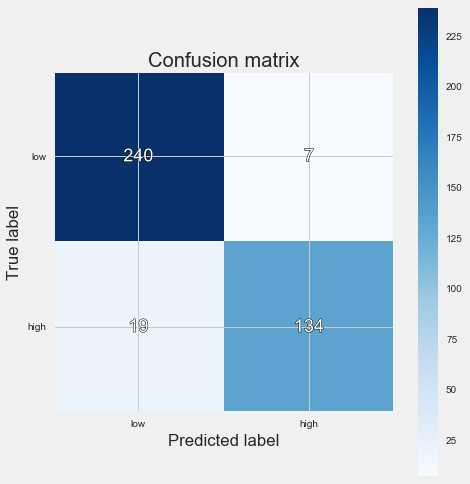

In [104]:
# plot confusion matrix
import numpy as np
plot_confusion_matrix(cmd,labels= ['low','high'],title='Confusion matrix', cmap=plt.cm.Blues,t_number =2)

In [106]:
# check important features for the best model
feature_importances = pd.DataFrame(gbdt.feature_importances_,
                                   index = xd.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print 'Gradient Boosting (Diversions):'
feature_importances.head(10)

Gradient Boosting (Diversions):


importance
metric_computation_dep    0.280926
metric_computation_arr    0.155753
avg_taxiout_delay         0.082303
cancel_arr                0.075329
avg_airborn_delay         0.070707
latitude                  0.068419
avg_block_delay           0.063517
cancel_dep                0.037664
longitude                 0.033847
avg_taxiin_delay          0.031268

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

https://lydiaxnc.wordpress.com/2016/07/28/project-7-blog-post/

Which operational features are most correlated with delays?

Based on our analysis, we can see that cancellations are mainly caused by diversions on arrivals, flights' metric computation (both departure and arrival), and average airborne delay. Diversions are due to flights' metric computation, taxi out delay, and average airborne delay. So now we can confidently speculate that taxi out delay, and airborne delay will lead to cancellation and diversion. However, we are not sure what factors in metric computation caused cancellations and diversions.  

What should the airport's next steps be?

As mentioned above, we need to further exam metric computation and see what factor (such as Airport Analysis, City Pair Analysis, Taxi Times, Individual Flights, Airport Efficiency, Throughput Analysis, and Weather Factors) in those scores lead to cancellations. Also looking more into ASPM (Aviation System Performance Metrics) for poorly performing regions. Maybe reroute connecting flights from poorly performing regions to better airports. 
 

### Bonus: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied